**1. Import the Module and Dependencies**

In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

# Force reload of the module to pick up changes
import importlib
import price_index_tools
importlib.reload(price_index_tools)

# Import our custom price index tools
from price_index_tools import (
    make_country_prices,
    make_weighted_price_index,
    plot_hs_prices,      # renamed from plot_hs6_prices
    plot_price_index
)

**2. Load and Prepare the Data**

Load the HS10-level import data and compute derived fields:
- `price`: unit value (value / quantity)
- `price_tariff`: unit value including tariff duties
- `tariff`: tariff rate as percentage
- `HS2`, `HS4`, `HS6`: higher-level aggregation codes

In [2]:
# Load the HS10-level import data
input_file = ".\\data-clean\\basic-imports-prices-hs10.parquet"
df = pd.read_parquet(input_file)

# Convert time to datetime
df.time = pd.to_datetime(df.time, format="%Y-%m")

# Convert numeric columns to float
df["CON_VAL_MO"] = df["CON_VAL_MO"].astype(float)
df["CON_QY1_MO"] = df["CON_QY1_MO"].astype(float)
df["CAL_DUT_MO"] = df["CAL_DUT_MO"].astype(float)

# Compute tariff rate (as percentage)
df["tariff"] = 100 * df["CAL_DUT_MO"] / df["CON_VAL_MO"]

# Compute unit values (prices)
df["price"] = df.CON_VAL_MO / df.CON_QY1_MO
df["price_tariff"] = df["price"] * (1 + df["tariff"] / 100)

# Replace infinite values with NaN
df["price"] = df["price"].replace([np.inf, -np.inf], np.nan)
df["price_tariff"] = df["price_tariff"].replace([np.inf, -np.inf], np.nan)

# Create HS code hierarchy columns
df["HS6"] = df["I_COMMODITY"].str[0:6]
df["HS4"] = df["I_COMMODITY"].str[0:4]
df["HS2"] = df["I_COMMODITY"].str[0:2]
# HS8 level (must create column first)
df["HS8"] = df["I_COMMODITY"].str[0:8]
df["HS10"] = df["I_COMMODITY"]

print(f"Loaded {len(df):,} rows")
print(f"Date range: {df.time.min()} to {df.time.max()}")
print(f"Countries: {df.CTY_NAME.nunique()}")
print(f"HS2 codes: {df.HS2.nunique()}")
print(f"HS4 codes: {df.HS4.nunique()}")
print(f"HS6 codes: {df.HS6.nunique()}")
print(f"HS8 codes: {df.HS8.nunique()}")
print(f"HS10 codes: {df.HS10.nunique()}")

df = df[df["CTY_NAME"] == 'TOTAL FOR ALL COUNTRIES']

Loaded 31,873,174 rows
Date range: 2013-01-01 00:00:00 to 2025-10-01 00:00:00
Countries: 33
HS2 codes: 98
HS4 codes: 1241
HS6 codes: 5828
HS8 codes: 12270
HS10 codes: 22645


In [3]:
df.head()

,time,I_COMMODITY,I_COMMODITY_SDESC,CTY_NAME,CON_VAL_MO,CAL_DUT_MO,CON_QY1_MO,tariff,price,price_tariff,HS6,HS4,HS2,HS8,HS10
29200770,2013-01-01,0602400000,"ROSES, GRAFTED OR NOT",TOTAL FOR ALL COUNTRIES,773010.0,0.0,398347.0,0.000000,1.940544,1.940544,060240,0602,06,06024000,0602400000
29200771,2013-01-01,0602902000,"ORCHID PLANTS, LIVE",TOTAL FOR ALL COUNTRIES,6177543.0,0.0,516771.0,0.000000,11.954121,11.954121,060290,0602,06,06029020,0602902000
29200772,2013-01-01,0602903010,CHRYSANTHEMUMS WITH SOIL ATTACHED TO ROOTS,TOTAL FOR ALL COUNTRIES,135786.0,0.0,49067.0,0.000000,2.767359,2.767359,060290,0602,06,06029030,0602903010
29200773,2013-01-01,0602903090,"HERBACEOUS PERENNIALS,WTH SOIL ATTACHED,LIVE,N...",TOTAL FOR ALL COUNTRIES,169439.0,0.0,50569.0,0.000000,3.350650,3.350650,060290,0602,06,06029030,0602903090
29200774,2013-01-01,0602904000,HERBACEOUS PERENNIALS WTHOUT SOIL ATTACHED NESOI,TOTAL FOR ALL COUNTRIES,2177498.0,25345.0,213738.0,1.163951,10.187697,10.306277,060290,0602,06,06029040,0602904000


In [4]:
dfenduse = pd.read_parquet("hs6-enduse.parquet")

dfenduse["ENDUSE"] = dfenduse["BEC5EndUse"]

dfenduse["HS6"] = dfenduse["HS6"].astype(str)

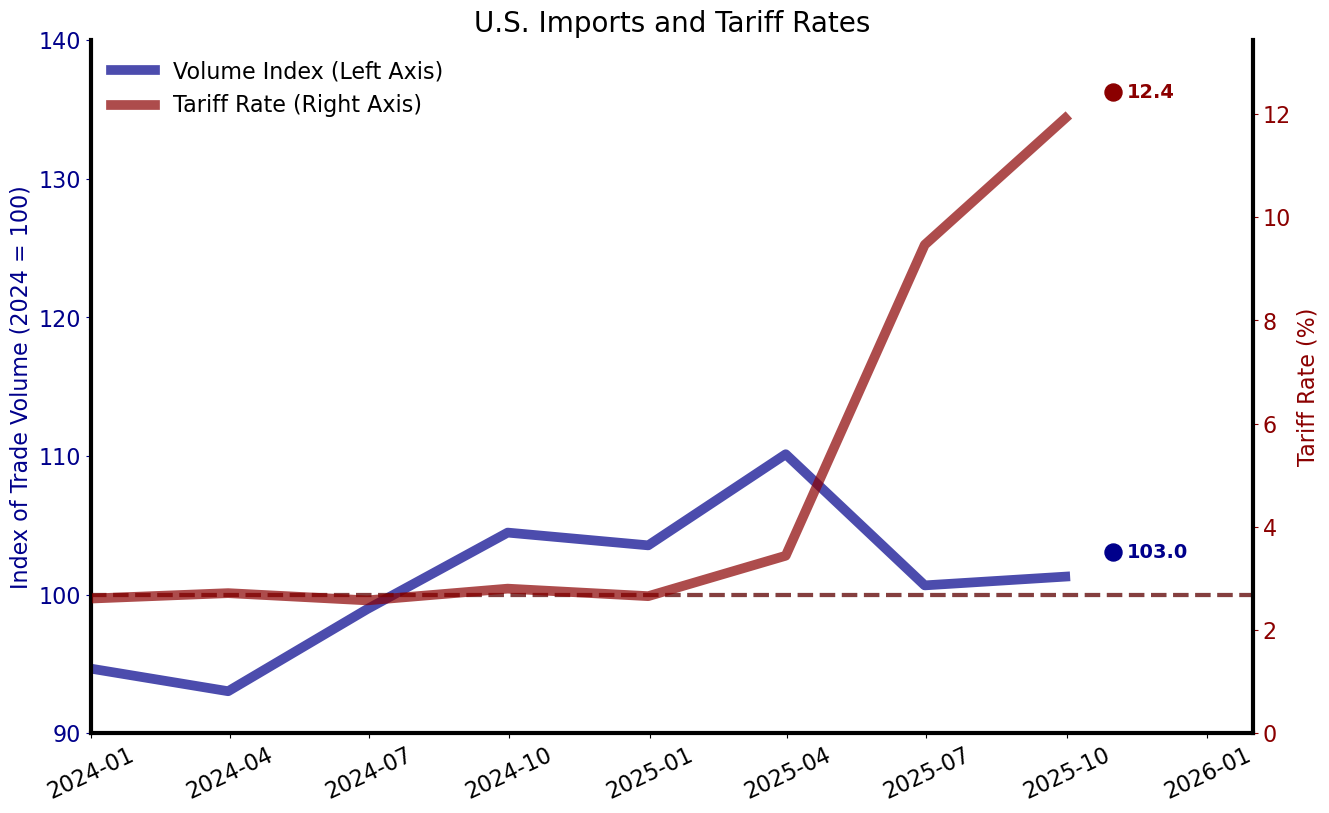

In [5]:
### This is the cell to try and get the ax.hlines lined up, yet see full range of things

index_year = "2024"

excluded_hs2 = ["27", "71", "98", "99"]

dfsec = df[~df["HS2"].isin(excluded_hs2)]

dfsec_quarterly = dfsec.set_index('time').resample('QE').agg({
    'CON_VAL_MO': 'sum',
    'CAL_DUT_MO': 'sum'
})
dfsec_quarterly['tariff'] = 100 * dfsec_quarterly['CAL_DUT_MO'] / dfsec_quarterly['CON_VAL_MO']

grp = dfsec_quarterly.groupby("time")

sec_trade = grp.agg({"CON_VAL_MO": "sum", "CAL_DUT_MO": "sum"}).reset_index()

sec_trade["tariff"] = 100 * sec_trade["CAL_DUT_MO"] / sec_trade["CON_VAL_MO"]

sec_trade.set_index("time", inplace=True)

#####################################################################################

fig, ax = plt.subplots(figsize = (15,9))

# Create second y-axis
ax2 = ax.twinx()

# Separate complete quarters from incomplete last quarter
sec_trade_complete = sec_trade.iloc[:-1]
sec_trade_last = sec_trade.iloc[-1]

# Plot volume on left axis (complete quarters)
ax.plot(sec_trade_complete.index, 100*(4*sec_trade_complete["CON_VAL_MO"] / sec_trade["CON_VAL_MO"].loc[index_year].sum()) , 
        color = "darkblue", alpha = 0.7, linewidth = 7, label="Volume Index (Left Axis)")

# Plot last incomplete quarter as a dot - aligned with October
october_date = dt.datetime(2025, 10, 31)
ax.scatter(october_date, 100*(12*sec_trade_last["CON_VAL_MO"] / sec_trade["CON_VAL_MO"].loc[index_year].sum()),
           color = "darkblue", s=150, zorder=5)

# Plot tariff on right axis (complete quarters)
ax2.plot(sec_trade_complete.index, sec_trade_complete["tariff"] , 
        color = "darkred", alpha = 0.7, linewidth = 7, label="Tariff Rate (Right Axis)")

# Plot last incomplete quarter as a dot - aligned with October
ax2.scatter(october_date, sec_trade_last["tariff"],
            color = "darkred", s=150, zorder=5)

# Add annotations for last observations
last_value_volume = 100*(12*sec_trade_last["CON_VAL_MO"] / sec_trade["CON_VAL_MO"].loc[index_year].sum())
ax.annotate(f'{last_value_volume:.1f}', 
            xy=(october_date, last_value_volume),
            xytext=(10, 0), textcoords='offset points',
            fontsize=14, fontweight='bold', color='darkblue',
            va='center')

last_value_tariff = sec_trade["tariff"].iloc[-1]
ax2.annotate(f'{last_value_tariff:.1f}', 
            xy=(october_date, last_value_tariff),
            xytext=(10, 0), textcoords='offset points',
            fontsize=14, fontweight='bold', color='darkred',
            va='center')

ax.set_title("U.S. Imports and Tariff Rates", fontsize = 20)

ax.set_xlim([dt.datetime(2024,1,1), dt.datetime(2026,1,31)])

ax.axhline(y=100, color='black', linestyle='--', linewidth=3, alpha=0.5)

tariff_baseline = sec_trade["tariff"].loc[index_year].mean()
ax2.axhline(y=tariff_baseline, color='darkred', linestyle='--', linewidth=3, alpha=0.5)

# Align horizontal lines at the same visual position
# Keep volume axis at a readable range
ax_min = 90
ax_max = 140

# Calculate the proportion where 100 sits on the volume axis
volume_proportion = (100 - ax_min) / (ax_max - ax_min)  # = 10/25 = 0.4 (40% from bottom)

# Set tariff axis so baseline sits at the same proportion
ax2_min = 0
ax2_max = tariff_baseline / volume_proportion

ax.set_ylim(ax_min, ax_max)
ax2.set_ylim(ax2_min, ax2_max)

ax.tick_params(axis='x', labelsize=16, rotation=25)
ax.tick_params(axis='y', labelsize=16)
ax2.tick_params(axis='y', labelsize=16)

ax.set_ylabel("Index of Trade Volume (" + index_year + " = 100)", fontsize=16, color="darkblue")
ax2.set_ylabel("Tariff Rate (%)", fontsize=16, color="darkred")

lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=16, frameon=False)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_linewidth(3)
ax.spines["bottom"].set_linewidth(3)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_linewidth(3)

# Color the y-axis labels to match the lines
ax.tick_params(axis='y', colors='darkblue')
ax2.tick_params(axis='y', colors='darkred')

plt.show()


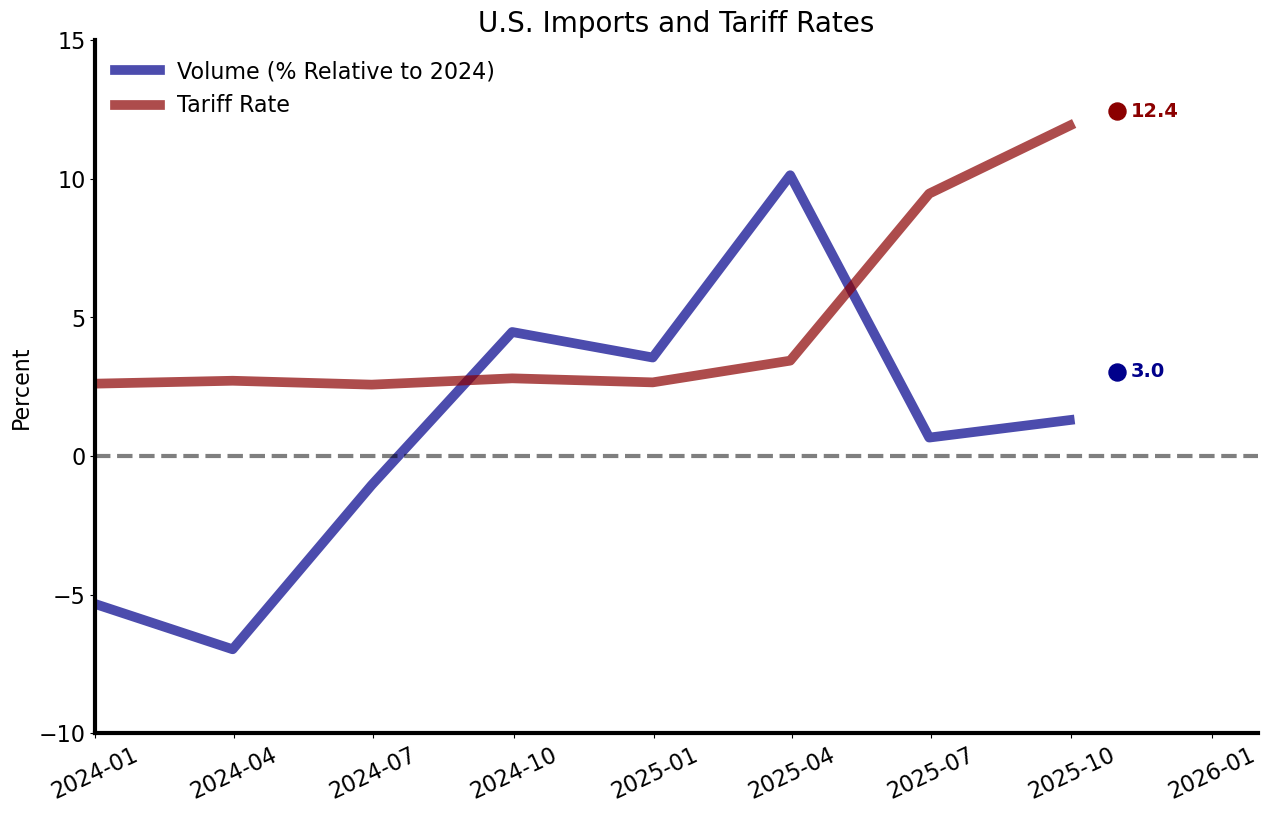

In [6]:
index_year = "2024"

excluded_hs2 = ["27", "71", "98", "99"]

dfsec = df[~df["HS2"].isin(excluded_hs2)]

dfsec_quarterly = dfsec.set_index('time').resample('QE').agg({
    'CON_VAL_MO': 'sum',
    'CAL_DUT_MO': 'sum'
})
dfsec_quarterly['tariff'] = 100 * dfsec_quarterly['CAL_DUT_MO'] / dfsec_quarterly['CON_VAL_MO']

grp = dfsec_quarterly.groupby("time")

sec_trade = grp.agg({"CON_VAL_MO": "sum", "CAL_DUT_MO": "sum"}).reset_index()

sec_trade["tariff"] = 100 * sec_trade["CAL_DUT_MO"] / sec_trade["CON_VAL_MO"]

sec_trade.set_index("time", inplace=True)

#####################################################################################

fig, ax = plt.subplots(figsize = (15,9))

# Create second y-axis
# ax2 = ax.twinx()

# Separate complete quarters from incomplete last quarter
sec_trade_complete = sec_trade.iloc[:-1]
sec_trade_last = sec_trade.iloc[-1]

# Plot volume on left axis (complete quarters)
ax.plot(sec_trade_complete.index, 100*(4*sec_trade_complete["CON_VAL_MO"] / sec_trade["CON_VAL_MO"].loc[index_year].sum() - 1) , 
        color = "darkblue", alpha = 0.7, linewidth = 7, label="Volume (% Relative to 2024)")

# Plot last incomplete quarter as a dot - aligned with October
october_date = dt.datetime(2025, 10, 31)
ax.scatter(october_date, 100*(12*sec_trade_last["CON_VAL_MO"] / sec_trade["CON_VAL_MO"].loc[index_year].sum()-1),
           color = "darkblue", s=150, zorder=5)

# Plot tariff on right axis (complete quarters)
ax.plot(sec_trade_complete.index, sec_trade_complete["tariff"] , 
        color = "darkred", alpha = 0.7, linewidth = 7, label="Tariff Rate")

# Plot last incomplete quarter as a dot - aligned with October
ax.scatter(october_date, sec_trade_last["tariff"],
            color = "darkred", s=150, zorder=5)

# Add annotations for last observations
last_value_volume = 100*(12*sec_trade_last["CON_VAL_MO"] / sec_trade["CON_VAL_MO"].loc[index_year].sum() - 1)
ax.annotate(f'{last_value_volume:.1f}', 
            xy=(october_date, last_value_volume),
            xytext=(10, 0), textcoords='offset points',
            fontsize=14, fontweight='bold', color='darkblue',
            va='center')

last_value_tariff = sec_trade["tariff"].iloc[-1]
ax.annotate(f'{last_value_tariff:.1f}', 
            xy=(october_date, last_value_tariff),
            xytext=(10, 0), textcoords='offset points',
            fontsize=14, fontweight='bold', color='darkred',
            va='center')

ax.set_title("U.S. Imports and Tariff Rates", fontsize = 20)

ax.set_xlim([dt.datetime(2024,1,1), dt.datetime(2026,1,31)])

ax.axhline(y=0, color='black', linestyle='--', linewidth=3, alpha=0.5)

# ax2.axhline(y=sec_trade["tariff"].loc[index_year].mean(), color='darkred', linestyle='--', linewidth=3, alpha=0.5)

ax.set_ylim(-10,15)
# ax2.set_ylim(0,15)  # Adjust as needed for tariff scale

ax.tick_params(axis='x', labelsize=16, rotation=25)
ax.tick_params(axis='y', labelsize=16)
# ax2.tick_params(axis='y', labelsize=16)

ax.set_ylabel("Percent", fontsize=16)
# ax2.set_ylabel("Tariff Rate (%)", fontsize=16, color="darkred")



ax.legend(loc='upper left', fontsize=16, frameon=False)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_linewidth(3)
ax.spines["bottom"].set_linewidth(3)
# ax2.spines["top"].set_visible(False)
# ax2.spines["right"].set_linewidth(3)

# # Color the y-axis labels to match the lines
# ax.tick_params(axis='y', colors='darkblue')

plt.show()


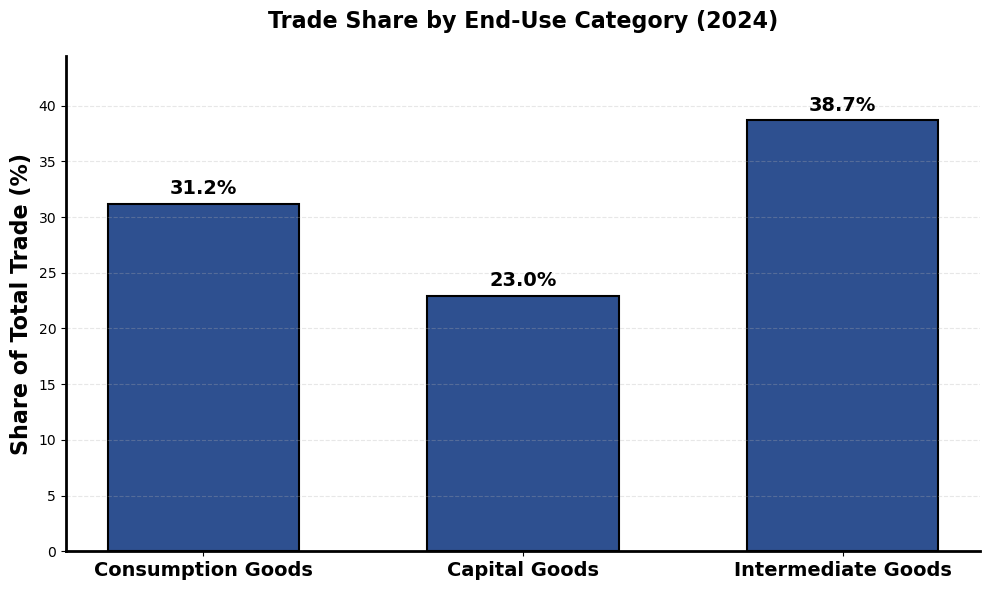


Trade Shares in 2024:
  Consumption Goods: 31.2%
  Capital Goods: 23.0%
  Intermediate Goods: 38.7%
  Total: 92.8%


In [7]:
# Trade share by end-use category
base_year = 2024  # Can change this to any year

excluded_hs2 = ["27", "30", "71", "88", "98", "99"]
df_filtered = df[~df["HS2"].isin(excluded_hs2)]

# Filter for the base year
df_year = df_filtered[df_filtered["time"].dt.year == base_year]

# Calculate total trade for the year
total_trade = df_year["CON_VAL_MO"].sum()

# Calculate trade by end-use category
categories = ["CONS", "CAP", "INT"]
trade_shares = []
category_labels = ["Consumption Goods", "Capital Goods", "Intermediate Goods"]

for cat in categories:
    cat_hs6 = dfenduse[dfenduse["ENDUSE"] == cat]["HS6"].unique()
    cat_trade = df_year[df_year["HS6"].isin(cat_hs6)]["CON_VAL_MO"].sum()
    share = (cat_trade / total_trade) * 100
    trade_shares.append(share)

# Create bar chart
fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(category_labels, trade_shares, color='#2E5090', edgecolor='black', linewidth=1.5, width=0.6)

# Add value labels on bars
for i, (label, share) in enumerate(zip(category_labels, trade_shares)):
    ax.text(i, share + 0.5, f'{share:.1f}%', 
            ha='center', va='bottom', fontsize=14, fontweight='bold')

# Formatting
ax.set_ylabel('Share of Total Trade (%)', fontsize=16, fontweight='bold')
ax.set_title(f'Trade Share by End-Use Category ({base_year})', fontsize=16, fontweight='bold', pad=20)
ax.set_ylim(0, max(trade_shares) * 1.15)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Make x-tick labels bold and larger
ax.tick_params(axis='x', labelsize=14)
for label in ax.get_xticklabels():
    label.set_fontweight('bold')

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_linewidth(2)
ax.spines["bottom"].set_linewidth(2)

plt.tight_layout()
plt.show()

print(f"\nTrade Shares in {base_year}:")
for label, share in zip(category_labels, trade_shares):
    print(f"  {label}: {share:.1f}%")
print(f"  Total: {sum(trade_shares):.1f}%")

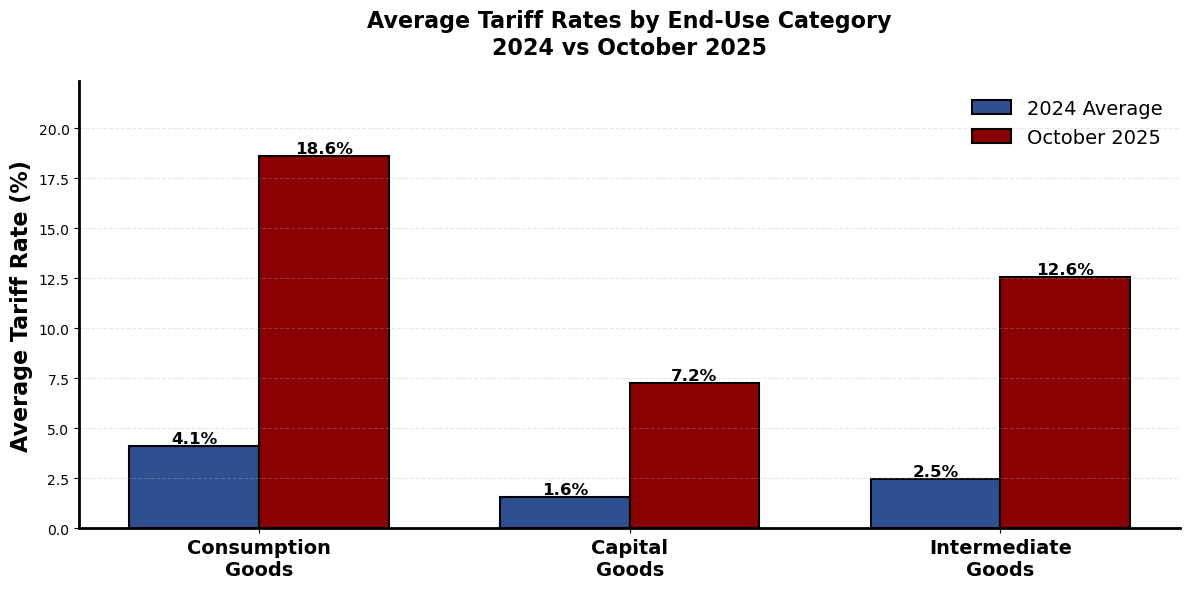


Average Tariff Rates:
  Consumption Goods:
    2024 Average: 4.12%
    October 2025: 18.63%
    Change: 14.50 percentage points
  Capital Goods:
    2024 Average: 1.56%
    October 2025: 7.25%
    Change: 5.69 percentage points
  Intermediate Goods:
    2024 Average: 2.46%
    October 2025: 12.55%
    Change: 10.09 percentage points


In [8]:
# Average tariff rates by end-use category: 2024 vs October 2025
excluded_hs2 = ["27", "71", "98", "99"]
df_filtered = df[~df["HS2"].isin(excluded_hs2)]

# Calculate tariff rates for 2024 and October 2025
categories = ["CONS", "CAP", "INT"]
category_labels = ["Consumption\nGoods", "Capital\nGoods", "Intermediate\nGoods"]
tariff_2024 = []
tariff_oct2025 = []

for cat in categories:
    cat_hs6 = dfenduse[dfenduse["ENDUSE"] == cat]["HS6"].unique()
    df_cat = df_filtered[df_filtered["HS6"].isin(cat_hs6)]
    
    # 2024 average tariff
    df_2024 = df_cat[df_cat["time"].dt.year == 2024]
    tariff_rate_2024 = 100 * df_2024["CAL_DUT_MO"].sum() / df_2024["CON_VAL_MO"].sum()
    tariff_2024.append(tariff_rate_2024)
    
    # October 2025 tariff
    df_oct2025 = df_cat[(df_cat["time"].dt.year == 2025) & (df_cat["time"].dt.month == 10)]
    tariff_rate_oct2025 = 100 * df_oct2025["CAL_DUT_MO"].sum() / df_oct2025["CON_VAL_MO"].sum()
    tariff_oct2025.append(tariff_rate_oct2025)

# Create grouped bar chart
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(category_labels))
width = 0.35

bars1 = ax.bar(x - width/2, tariff_2024, width, label='2024 Average', 
               color='#2E5090', edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, tariff_oct2025, width, label='October 2025',
               color='darkred', edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom', fontsize=12, fontweight='bold')

# Formatting
ax.set_ylabel('Average Tariff Rate (%)', fontsize=16, fontweight='bold')
ax.set_title('Average Tariff Rates by End-Use Category\n2024 vs October 2025', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(category_labels)
ax.legend(fontsize=14, frameon=False, loc='upper right')
ax.set_ylim(0, max(max(tariff_2024), max(tariff_oct2025)) * 1.2)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Make x-tick labels bold and larger
ax.tick_params(axis='x', labelsize=14)
for label in ax.get_xticklabels():
    label.set_fontweight('bold')

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_linewidth(2)
ax.spines["bottom"].set_linewidth(2)

plt.tight_layout()
plt.show()

print(f"\nAverage Tariff Rates:")
for label, t2024, toct2025 in zip(["Consumption Goods", "Capital Goods", "Intermediate Goods"], 
                                   tariff_2024, tariff_oct2025):
    print(f"  {label}:")
    print(f"    2024 Average: {t2024:.2f}%")
    print(f"    October 2025: {toct2025:.2f}%")
    print(f"    Change: {toct2025 - t2024:.2f} percentage points")

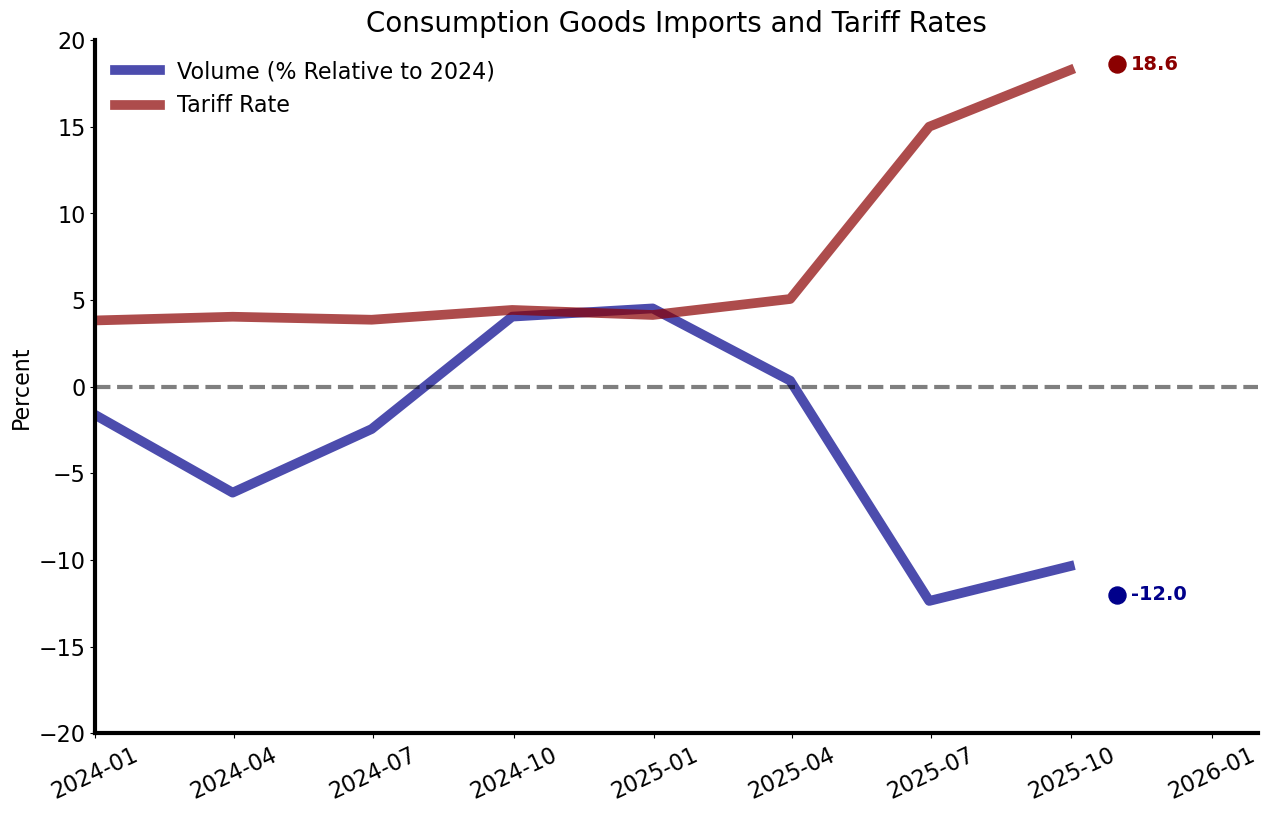

In [9]:
index_year = "2024"

excluded_hs2 = ["27", "71", "98", "99"]

dfsec = df[~df["HS2"].isin(excluded_hs2)]

dfsec = dfsec[dfsec["HS6"].isin(dfenduse[dfenduse["ENDUSE"] == "CONS"]["HS6"].unique())]

dfsec_quarterly = dfsec.set_index('time').resample('QE').agg({
    'CON_VAL_MO': 'sum',
    'CAL_DUT_MO': 'sum'
})
dfsec_quarterly['tariff'] = 100 * dfsec_quarterly['CAL_DUT_MO'] / dfsec_quarterly['CON_VAL_MO']

grp = dfsec_quarterly.groupby("time")

sec_trade = grp.agg({"CON_VAL_MO": "sum", "CAL_DUT_MO": "sum"}).reset_index()

sec_trade["tariff"] = 100 * sec_trade["CAL_DUT_MO"] / sec_trade["CON_VAL_MO"]

sec_trade.set_index("time", inplace=True)

#####################################################################################

fig, ax = plt.subplots(figsize = (15,9))

# Create second y-axis
# ax2 = ax.twinx()

# Separate complete quarters from incomplete last quarter
sec_trade_complete = sec_trade.iloc[:-1]
sec_trade_last = sec_trade.iloc[-1]

# Plot volume on left axis (complete quarters)
ax.plot(sec_trade_complete.index, 100*(4*sec_trade_complete["CON_VAL_MO"] / sec_trade["CON_VAL_MO"].loc[index_year].sum() - 1) , 
        color = "darkblue", alpha = 0.7, linewidth = 7, label="Volume (% Relative to 2024)")

# Plot last incomplete quarter as a dot - aligned with October
october_date = dt.datetime(2025, 10, 31)
ax.scatter(october_date, 100*(12*sec_trade_last["CON_VAL_MO"] / sec_trade["CON_VAL_MO"].loc[index_year].sum()-1),
           color = "darkblue", s=150, zorder=5)

# Plot tariff on right axis (complete quarters)
ax.plot(sec_trade_complete.index, sec_trade_complete["tariff"] , 
        color = "darkred", alpha = 0.7, linewidth = 7, label="Tariff Rate")

# Plot last incomplete quarter as a dot - aligned with October
ax.scatter(october_date, sec_trade_last["tariff"],
            color = "darkred", s=150, zorder=5)

# Add annotations for last observations
last_value_volume = 100*(12*sec_trade_last["CON_VAL_MO"] / sec_trade["CON_VAL_MO"].loc[index_year].sum() - 1)
ax.annotate(f'{last_value_volume:.1f}', 
            xy=(october_date, last_value_volume),
            xytext=(10, 0), textcoords='offset points',
            fontsize=14, fontweight='bold', color='darkblue',
            va='center')

last_value_tariff = sec_trade["tariff"].iloc[-1]
ax.annotate(f'{last_value_tariff:.1f}', 
            xy=(october_date, last_value_tariff),
            xytext=(10, 0), textcoords='offset points',
            fontsize=14, fontweight='bold', color='darkred',
            va='center')

ax.set_title("Consumption Goods Imports and Tariff Rates", fontsize = 20)

ax.set_xlim([dt.datetime(2024,1,1), dt.datetime(2026,1,31)])

ax.axhline(y=0, color='black', linestyle='--', linewidth=3, alpha=0.5)

# ax2.axhline(y=sec_trade["tariff"].loc[index_year].mean(), color='darkred', linestyle='--', linewidth=3, alpha=0.5)

ax.set_ylim(-20,20)
# ax2.set_ylim(0,20)  # Adjust as needed for tariff scale

ax.tick_params(axis='x', labelsize=16, rotation=25)
ax.tick_params(axis='y', labelsize=16)
# ax2.tick_params(axis='y', labelsize=16)

# ax2.tick_params(axis='y', colors='darkred')

ax.set_ylabel("Percent", fontsize=16)
# ax.tick_params(axis='y', colors='darkblue')

# ax2.set_ylabel("Tariff Rate (%)", fontsize=16, color="darkred")# Color the y-axis labels to match the lines


ax.legend(loc='upper left', fontsize=16, frameon=False)
# ax2.spines["right"].set_linewidth(3)

# lines2, labels2 = ax2.get_legend_handles_labels()
# ax2.spines["top"].set_visible(False)

# ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=16, frameon=False)
ax.spines["bottom"].set_linewidth(3)

ax.spines["left"].set_linewidth(3)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.show()

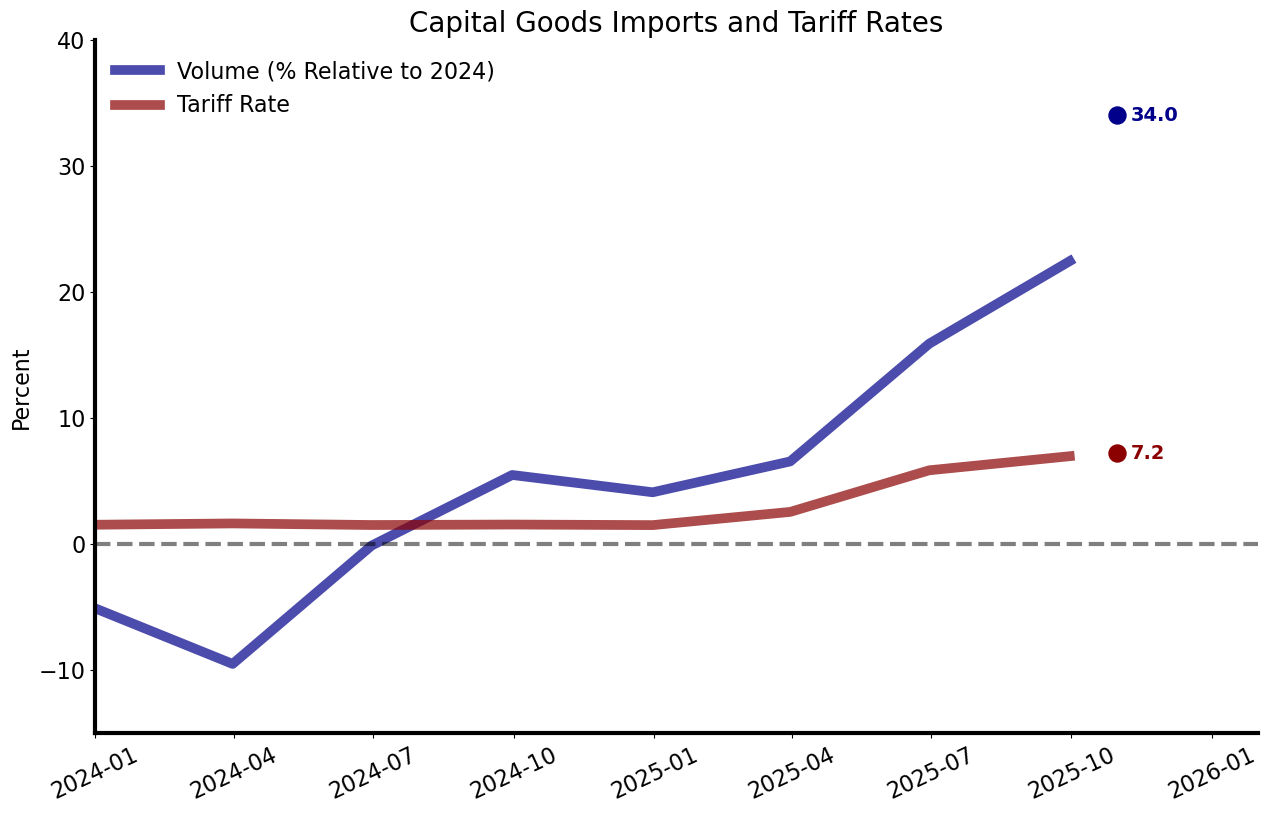

In [10]:
index_year = "2024"

excluded_hs2 = ["27", "71", "98", "99"]

dfsec = df[~df["HS2"].isin(excluded_hs2)]

dfsec = dfsec[dfsec["HS6"].isin(dfenduse[dfenduse["ENDUSE"] == "CAP"]["HS6"].unique())]

dfsec_quarterly = dfsec.set_index('time').resample('QE').agg({
    'CON_VAL_MO': 'sum',
    'CAL_DUT_MO': 'sum'
})
dfsec_quarterly['tariff'] = 100 * dfsec_quarterly['CAL_DUT_MO'] / dfsec_quarterly['CON_VAL_MO']

grp = dfsec_quarterly.groupby("time")

sec_trade = grp.agg({"CON_VAL_MO": "sum", "CAL_DUT_MO": "sum"}).reset_index()

sec_trade["tariff"] = 100 * sec_trade["CAL_DUT_MO"] / sec_trade["CON_VAL_MO"]

sec_trade.set_index("time", inplace=True)

#####################################################################################

fig, ax = plt.subplots(figsize = (15,9))

# Create second y-axis
# ax2 = ax.twinx()

# Separate complete quarters from incomplete last quarter
sec_trade_complete = sec_trade.iloc[:-1]
sec_trade_last = sec_trade.iloc[-1]

# Plot volume on left axis (complete quarters)
ax.plot(sec_trade_complete.index, 100*(4*sec_trade_complete["CON_VAL_MO"] / sec_trade["CON_VAL_MO"].loc[index_year].sum() - 1) , 
        color = "darkblue", alpha = 0.7, linewidth = 7, label="Volume (% Relative to 2024)")

# Plot last incomplete quarter as a dot - aligned with October
october_date = dt.datetime(2025, 10, 31)
ax.scatter(october_date, 100*(12*sec_trade_last["CON_VAL_MO"] / sec_trade["CON_VAL_MO"].loc[index_year].sum()-1),
           color = "darkblue", s=150, zorder=5)

# Plot tariff on right axis (complete quarters)
ax.plot(sec_trade_complete.index, sec_trade_complete["tariff"] , 
        color = "darkred", alpha = 0.7, linewidth = 7, label="Tariff Rate")

# Plot last incomplete quarter as a dot - aligned with October
ax.scatter(october_date, sec_trade_last["tariff"],
            color = "darkred", s=150, zorder=5)

# Add annotations for last observations
last_value_volume = 100*(12*sec_trade_last["CON_VAL_MO"] / sec_trade["CON_VAL_MO"].loc[index_year].sum() - 1)
ax.annotate(f'{last_value_volume:.1f}', 
            xy=(october_date, last_value_volume),
            xytext=(10, 0), textcoords='offset points',
            fontsize=14, fontweight='bold', color='darkblue',
            va='center')

last_value_tariff = sec_trade["tariff"].iloc[-1]
ax.annotate(f'{last_value_tariff:.1f}', 
            xy=(october_date, last_value_tariff),
            xytext=(10, 0), textcoords='offset points',
            fontsize=14, fontweight='bold', color='darkred',
            va='center')

ax.set_title("Capital Goods Imports and Tariff Rates", fontsize = 20)

ax.set_xlim([dt.datetime(2024,1,1), dt.datetime(2026,1,31)])

ax.axhline(y=0, color='black', linestyle='--', linewidth=3, alpha=0.5)

# ax2.axhline(y=sec_trade["tariff"].loc[index_year].mean(), color='darkred', linestyle='--', linewidth=3, alpha=0.5)

ax.set_ylim(-15,40)
# ax2.set_ylim(0,25)  # Adjust as needed for tariff scale

ax.tick_params(axis='x', labelsize=16, rotation=25)
ax.tick_params(axis='y', labelsize=16)
# ax2.tick_params(axis='y', labelsize=16)

ax.set_ylabel("Percent", fontsize=16)
# ax2.set_ylabel("Tariff Rate (%)", fontsize=16, color="darkred")



ax.legend(loc='upper left', fontsize=16, frameon=False)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_linewidth(3)
ax.spines["bottom"].set_linewidth(3)
# ax2.spines["top"].set_visible(False)
# ax2.spines["right"].set_linewidth(3)

# # Color the y-axis labels to match the lines
# ax.tick_params(axis='y', colors='darkblue')

plt.show()


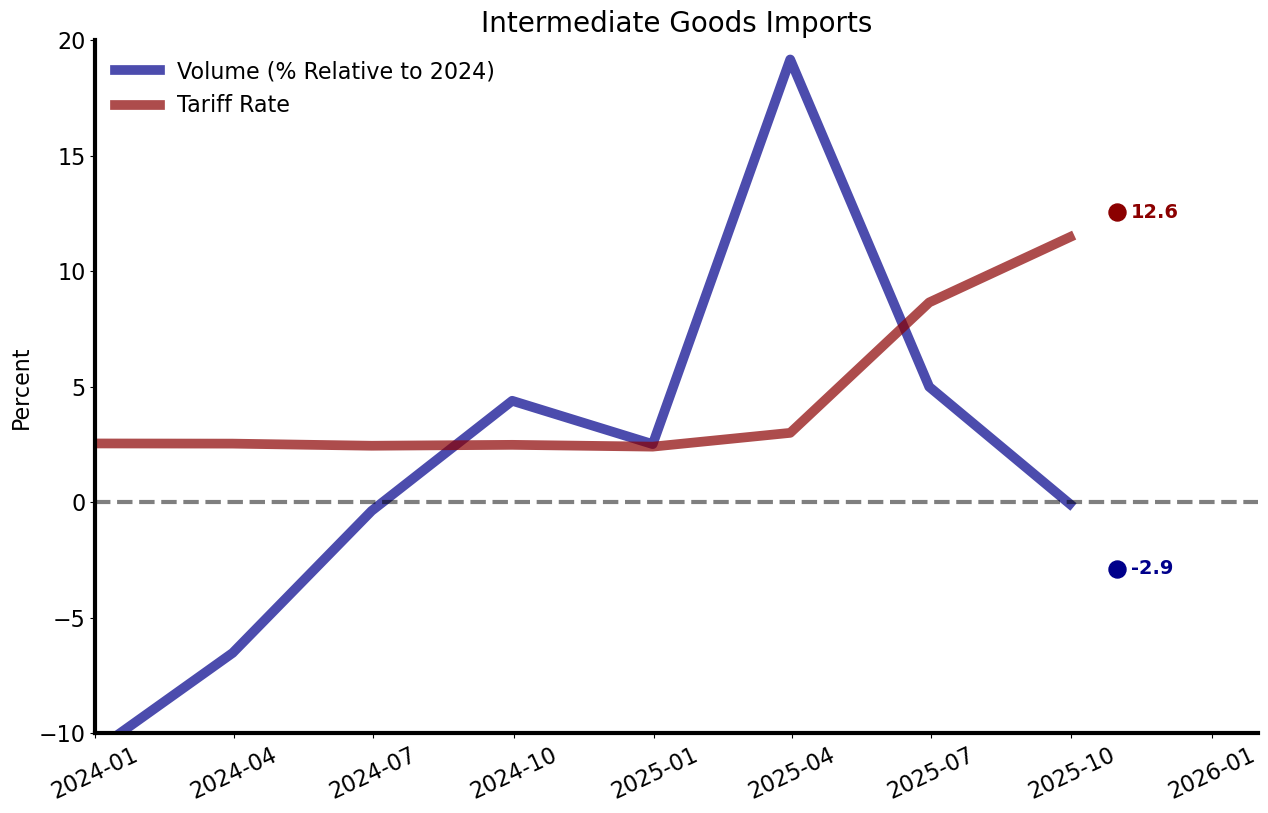

In [11]:
index_year = "2024"

excluded_hs2 = ["27", "71", "98", "99"]

dfsec = df[~df["HS2"].isin(excluded_hs2)]

dfsec = dfsec[dfsec["HS6"].isin(dfenduse[dfenduse["ENDUSE"] == "INT"]["HS6"].unique())]

dfsec_quarterly = dfsec.set_index('time').resample('QE').agg({
    'CON_VAL_MO': 'sum',
    'CAL_DUT_MO': 'sum'
})
dfsec_quarterly['tariff'] = 100 * dfsec_quarterly['CAL_DUT_MO'] / dfsec_quarterly['CON_VAL_MO']

grp = dfsec_quarterly.groupby("time")

sec_trade = grp.agg({"CON_VAL_MO": "sum", "CAL_DUT_MO": "sum"}).reset_index()

sec_trade["tariff"] = 100 * sec_trade["CAL_DUT_MO"] / sec_trade["CON_VAL_MO"]

sec_trade.set_index("time", inplace=True)

#####################################################################################

fig, ax = plt.subplots(figsize = (15,9))

# Create second y-axis
# ax2 = ax.twinx()

# Separate complete quarters from incomplete last quarter
sec_trade_complete = sec_trade.iloc[:-1]
sec_trade_last = sec_trade.iloc[-1]

# Plot volume on left axis (complete quarters)
ax.plot(sec_trade_complete.index, 100*(4*sec_trade_complete["CON_VAL_MO"] / sec_trade["CON_VAL_MO"].loc[index_year].sum() - 1) , 
        color = "darkblue", alpha = 0.7, linewidth = 7, label="Volume (% Relative to 2024)")

# Plot last incomplete quarter as a dot - aligned with October
october_date = dt.datetime(2025, 10, 31)
ax.scatter(october_date, 100*(12*sec_trade_last["CON_VAL_MO"] / sec_trade["CON_VAL_MO"].loc[index_year].sum()-1),
           color = "darkblue", s=150, zorder=5)

# Plot tariff on right axis (complete quarters)
ax.plot(sec_trade_complete.index, sec_trade_complete["tariff"] , 
        color = "darkred", alpha = 0.7, linewidth = 7, label="Tariff Rate")

# Plot last incomplete quarter as a dot - aligned with October
ax.scatter(october_date, sec_trade_last["tariff"],
            color = "darkred", s=150, zorder=5)

# Add annotations for last observations
last_value_volume = 100*(12*sec_trade_last["CON_VAL_MO"] / sec_trade["CON_VAL_MO"].loc[index_year].sum() - 1)
ax.annotate(f'{last_value_volume:.1f}', 
            xy=(october_date, last_value_volume),
            xytext=(10, 0), textcoords='offset points',
            fontsize=14, fontweight='bold', color='darkblue',
            va='center')

last_value_tariff = sec_trade["tariff"].iloc[-1]
ax.annotate(f'{last_value_tariff:.1f}', 
            xy=(october_date, last_value_tariff),
            xytext=(10, 0), textcoords='offset points',
            fontsize=14, fontweight='bold', color='darkred',
            va='center')

ax.set_title("Intermediate Goods Imports", fontsize = 20)

ax.set_xlim([dt.datetime(2024,1,1), dt.datetime(2026,1,31)])

ax.axhline(y=0, color='black', linestyle='--', linewidth=3, alpha=0.5)

# ax2.axhline(y=sec_trade["tariff"].loc[index_year].mean(), color='darkred', linestyle='--', linewidth=3, alpha=0.5)

ax.set_ylim(-10,20)
# ax2.set_ylim(0,20)  # Adjust as needed for tariff scale

ax.tick_params(axis='x', labelsize=16, rotation=25)
ax.tick_params(axis='y', labelsize=16)
# ax2.tick_params(axis='y', labelsize=16)

# ax2.tick_params(axis='y', colors='darkred')

ax.set_ylabel("Percent", fontsize=16)
# ax.tick_params(axis='y', colors='darkblue')

# ax2.set_ylabel("Tariff Rate (%)", fontsize=16, color="darkred")# Color the y-axis labels to match the lines



ax.legend(loc='upper left', fontsize=16, frameon=False)
# ax2.spines["right"].set_linewidth(3)

# lines2, labels2 = ax2.get_legend_handles_labels()
# ax2.spines["top"].set_visible(False)

# ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=16, frameon=False)
ax.spines["bottom"].set_linewidth(3)

ax.spines["left"].set_linewidth(3)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.show()

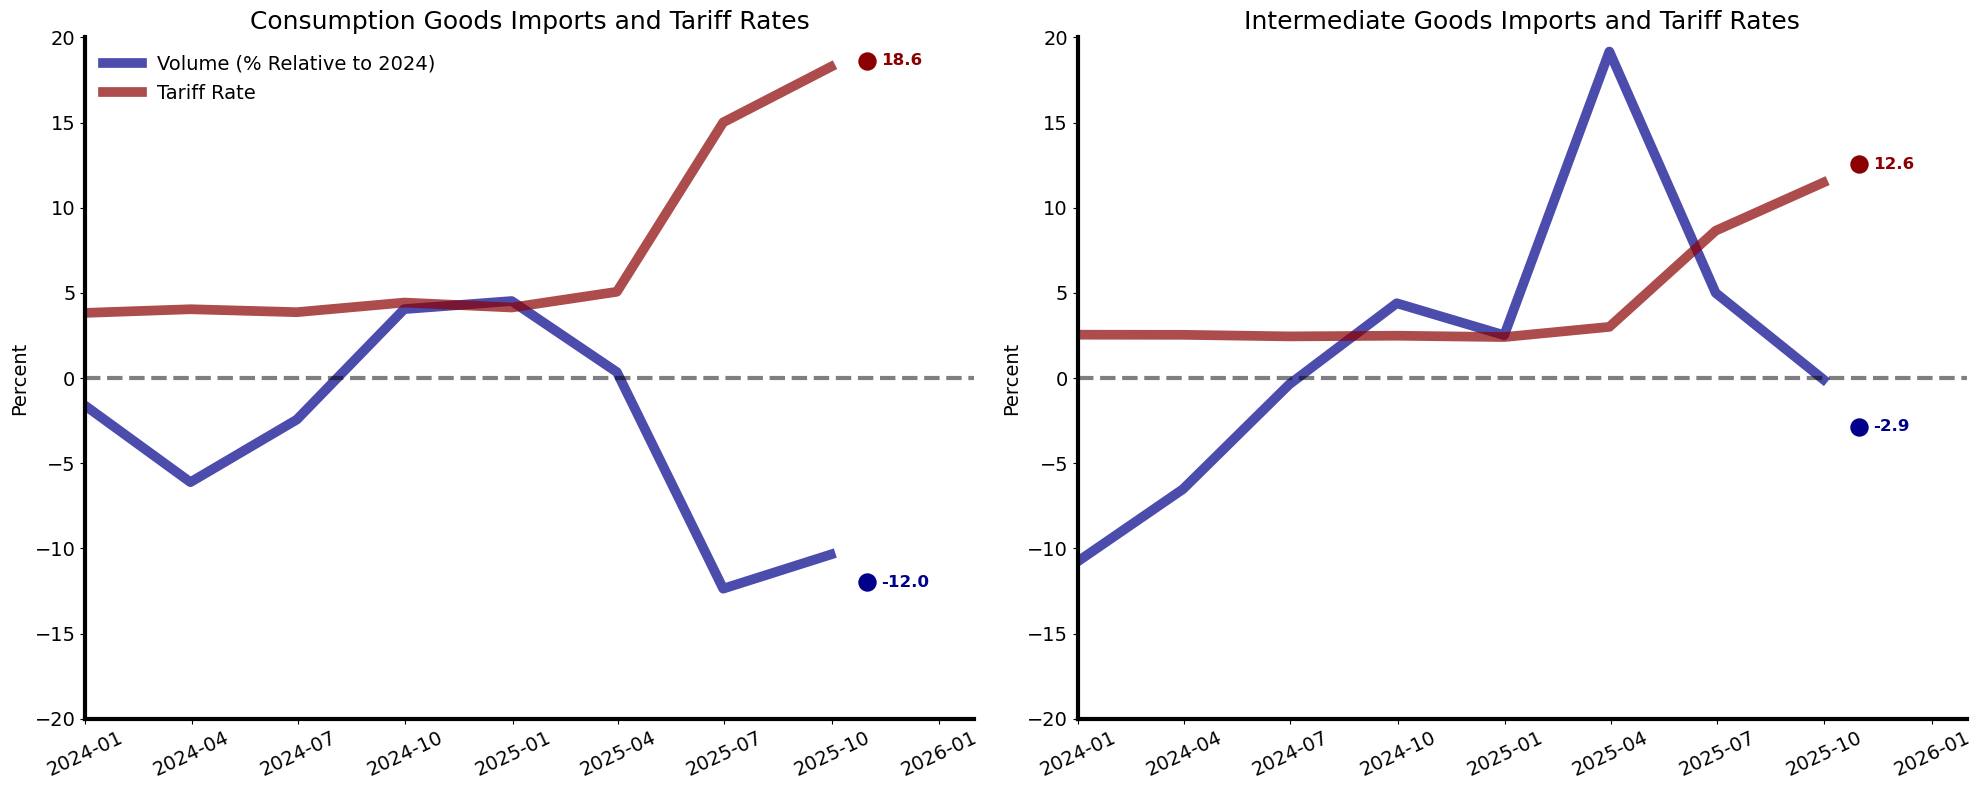

In [12]:
index_year = "2024"

# Dual panel: Consumption Goods and Intermediate Goods
fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(20, 8))

excluded_hs2 = ["27", "71", "98", "99"]

# ========== PANEL 1: CONSUMPTION GOODS ==========
dfsec_cap = df[~df["HS2"].isin(excluded_hs2)]
dfsec_cap = dfsec_cap[dfsec_cap["HS6"].isin(dfenduse[dfenduse["ENDUSE"] == "CONS"]["HS6"].unique())]

dfsec_cap_quarterly = dfsec_cap.set_index('time').resample('QE').agg({
    'CON_VAL_MO': 'sum',
    'CAL_DUT_MO': 'sum'
})
dfsec_cap_quarterly['tariff'] = 100 * dfsec_cap_quarterly['CAL_DUT_MO'] / dfsec_cap_quarterly['CON_VAL_MO']

sec_trade_cap = dfsec_cap_quarterly.groupby("time").agg({"CON_VAL_MO": "sum", "CAL_DUT_MO": "sum"}).reset_index()
sec_trade_cap["tariff"] = 100 * sec_trade_cap["CAL_DUT_MO"] / sec_trade_cap["CON_VAL_MO"]
sec_trade_cap.set_index("time", inplace=True)

# Create second y-axis for panel 1
# ax2 = ax1.twinx()

# Separate complete quarters from incomplete last quarter
sec_trade_cap_complete = sec_trade_cap.iloc[:-1]
sec_trade_cap_last = sec_trade_cap.iloc[-1]

# Plot volume on left axis (complete quarters)
ax1.plot(sec_trade_cap_complete.index, 100*(4*sec_trade_cap_complete["CON_VAL_MO"] / sec_trade_cap["CON_VAL_MO"].loc[index_year].sum() - 1) , 
        color = "darkblue", alpha = 0.7, linewidth = 7, label="Volume (% Relative to 2024)")

# Plot last incomplete quarter as a dot - aligned with October
october_date = dt.datetime(2025, 10, 31)
ax1.scatter(october_date, 100*(12*sec_trade_cap_last["CON_VAL_MO"] / sec_trade_cap["CON_VAL_MO"].loc[index_year].sum()-1),
           color = "darkblue", s=150, zorder=5)

# Plot tariff on right axis (complete quarters)
ax1.plot(sec_trade_cap_complete.index, sec_trade_cap_complete["tariff"] , 
        color = "darkred", alpha = 0.7, linewidth = 7, label="Tariff Rate")

# Plot last incomplete quarter as a dot - aligned with October
ax1.scatter(october_date, sec_trade_cap_last["tariff"],
            color = "darkred", s=150, zorder=5)

# Add annotations for last observations
last_value_volume_cap = 100*(12*sec_trade_cap_last["CON_VAL_MO"] / sec_trade_cap["CON_VAL_MO"].loc[index_year].sum() - 1)
ax1.annotate(f'{last_value_volume_cap:.1f}', 
            xy=(october_date, last_value_volume_cap),
            xytext=(10, 0), textcoords='offset points',
            fontsize=12, fontweight='bold', color='darkblue',
            va='center')

last_value_tariff_cap = sec_trade_cap["tariff"].iloc[-1]
ax1.annotate(f'{last_value_tariff_cap:.1f}', 
            xy=(october_date, last_value_tariff_cap),
            xytext=(10, 0), textcoords='offset points',
            fontsize=12, fontweight='bold', color='darkred',
            va='center')

ax1.set_title("Consumption Goods Imports and Tariff Rates", fontsize = 18)
ax1.set_xlim([dt.datetime(2024,1,1), dt.datetime(2026,1,31)])
ax1.axhline(y=0, color='black', linestyle='--', linewidth=3, alpha=0.5)
# ax2.axhline(y=sec_trade_cap["tariff"].loc[index_year].mean(), color='darkred', linestyle='--', linewidth=3, alpha=0.5)
ax1.set_ylim(-20,20)
# ax2.set_ylim(0,20)

ax1.tick_params(axis='x', labelsize=14, rotation=25)
ax1.tick_params(axis='y', labelsize=14)
# ax2.tick_params(axis='y', labelsize=14, colors='darkred', labelleft=False, labelright=False)

ax1.set_ylabel("Percent", fontsize=14)

ax1.legend(loc='upper left', fontsize=14, frameon=False)

ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["left"].set_linewidth(3)
ax1.spines["bottom"].set_linewidth(3)
# ax2.spines["top"].set_visible(False)
# ax2.spines["right"].set_linewidth(3)

# ========== PANEL 2: INTERMEDIATE GOODS ==========
dfsec_int = df[~df["HS2"].isin(excluded_hs2)]
dfsec_int = dfsec_int[dfsec_int["HS6"].isin(dfenduse[dfenduse["ENDUSE"] == "INT"]["HS6"].unique())]

dfsec_int_quarterly = dfsec_int.set_index('time').resample('QE').agg({
    'CON_VAL_MO': 'sum',
    'CAL_DUT_MO': 'sum'
})
dfsec_int_quarterly['tariff'] = 100 * dfsec_int_quarterly['CAL_DUT_MO'] / dfsec_int_quarterly['CON_VAL_MO']

sec_trade_int = dfsec_int_quarterly.groupby("time").agg({"CON_VAL_MO": "sum", "CAL_DUT_MO": "sum"}).reset_index()
sec_trade_int["tariff"] = 100 * sec_trade_int["CAL_DUT_MO"] / sec_trade_int["CON_VAL_MO"]
sec_trade_int.set_index("time", inplace=True)

# Create second y-axis for panel 2
# ax4 = ax3.twinx()

# Separate complete quarters from incomplete last quarter
sec_trade_int_complete = sec_trade_int.iloc[:-1]
sec_trade_int_last = sec_trade_int.iloc[-1]

# Plot volume on left axis (complete quarters)
ax3.plot(sec_trade_int_complete.index, 100*(4*sec_trade_int_complete["CON_VAL_MO"] / sec_trade_int["CON_VAL_MO"].loc[index_year].sum() - 1) , 
        color = "darkblue", alpha = 0.7, linewidth = 7, label="Volume (% Relative to 2024)")

# Plot last incomplete quarter as a dot - aligned with October
ax3.scatter(october_date, 100*(12*sec_trade_int_last["CON_VAL_MO"] / sec_trade_int["CON_VAL_MO"].loc[index_year].sum()-1),
           color = "darkblue", s=150, zorder=5)

# Plot tariff on right axis (complete quarters)
ax3.plot(sec_trade_int_complete.index, sec_trade_int_complete["tariff"] , 
        color = "darkred", alpha = 0.7, linewidth = 7, label="Tariff Rate")

# Plot last incomplete quarter as a dot - aligned with October
ax3.scatter(october_date, sec_trade_int_last["tariff"],
            color = "darkred", s=150, zorder=5)

# Add annotations for last observations
last_value_volume_int = 100*(12*sec_trade_int_last["CON_VAL_MO"] / sec_trade_int["CON_VAL_MO"].loc[index_year].sum() - 1)
ax3.annotate(f'{last_value_volume_int:.1f}', 
            xy=(october_date, last_value_volume_int),
            xytext=(10, 0), textcoords='offset points',
            fontsize=12, fontweight='bold', color='darkblue',
            va='center')

last_value_tariff_int = sec_trade_int["tariff"].iloc[-1]
ax3.annotate(f'{last_value_tariff_int:.1f}', 
            xy=(october_date, last_value_tariff_int),
            xytext=(10, 0), textcoords='offset points',
            fontsize=12, fontweight='bold', color='darkred',
            va='center')

ax3.set_title("Intermediate Goods Imports and Tariff Rates", fontsize = 18)
ax3.set_xlim([dt.datetime(2024,1,1), dt.datetime(2026,1,31)])
ax3.axhline(y=0, color='black', linestyle='--', linewidth=3, alpha=0.5)
# ax4.axhline(y=sec_trade_int["tariff"].loc[index_year].mean(), color='darkred', linestyle='--', linewidth=3, alpha=0.5)
ax3.set_ylim(-20,20)
# ax4.set_ylim(0,20)

ax3.tick_params(axis='x', labelsize=14, rotation=25)
ax3.tick_params(axis='y', labelsize=14)
# ax4.tick_params(axis='y', labelsize=14, colors='darkred')

ax3.set_ylabel("Percent", fontsize=14)

ax3.spines["right"].set_visible(False)
ax3.spines["top"].set_visible(False)
ax3.spines["left"].set_linewidth(3)
ax3.spines["bottom"].set_linewidth(3)
# ax4.spines["top"].set_visible(False)
# ax4.spines["right"].set_linewidth(3)

plt.tight_layout()
plt.show()


In [13]:
matlist = pd.read_csv('c:\\github\\ai-trade-index\\hs10_classification_final.csv')

# matlist = pd.read_csv('hs10_datacenter_relevance.csv')

# Convert to category
matlist['relevance'] = matlist['relevance'].astype('category')

# Or specify order if needed (e.g., for sorting/comparisons)
matlist['relevance'] = pd.Categorical(
    matlist['relevance'], 
    categories=['Low', 'Medium', 'High'], 
    ordered=True
)

matlist.rename(columns={'hs10_code': 'HS10'}, inplace=True)

# matlist["HS10"] = matlist["HS10"].astype(str)

In [14]:
df["HS10"] = df["HS10"].astype(int)

# Merge Relevance category from matlist onto df
df = df.merge(matlist[['HS10', 'relevance', "specific_use"]], on='HS10', how='left')

# # Combine High and Medium into a single category
# df['Relevance'] = df['Relevance'].cat.add_categories(['High/Medium'])

# df.loc[df['Relevance'].isin(['High', 'Medium']), 'Relevance'] = 'High/Medium'

# df['Relevance'] = df['Relevance'].cat.remove_unused_categories()

In [15]:
df.tail()

,time,I_COMMODITY,I_COMMODITY_SDESC,CTY_NAME,CON_VAL_MO,CAL_DUT_MO,CON_QY1_MO,tariff,price,price_tariff,HS6,HS4,HS2,HS8,HS10,relevance,specific_use
2672399,2025-10-01,2918120000,TARTARIC ACID,TOTAL FOR ALL COUNTRIES,1345678.0,411161.0,437920.0,30.554189,3.072885,4.011781,291812,2918,29,29181200,2918120000,Low,Not applicable to data center operations
2672400,2025-10-01,2918131000,POTASSIUM ANTIMONY TARTRATE (TARTER EMETIC),TOTAL FOR ALL COUNTRIES,0.0,0.0,0.0,NaN,NaN,NaN,291813,2918,29,29181310,2918131000,Low,Not applicable to data center operations
2672401,2025-10-01,2918132000,POTASSIUM BITARTRATE (CREAM OF TARTER),TOTAL FOR ALL COUNTRIES,445887.0,87953.0,141800.0,19.725401,3.144478,3.764739,291813,2918,29,29181320,2918132000,Low,Food additive/baking ingredient - not used in ...
2672402,2025-10-01,2918133000,POTASSIUM SODIUM TARTRATE (ROCHELLE SALTS),TOTAL FOR ALL COUNTRIES,6406.0,1074.0,1005.0,16.765532,6.374129,7.442786,291813,2918,29,29181330,2918133000,Low,Not applicable to data center operations
2672403,2025-10-01,2918135000,OTHER ESTERS OF TARTARIC ACID,TOTAL FOR ALL COUNTRIES,5006.0,0.0,260.0,0.000000,19.253846,19.253846,291813,2918,29,29181350,2918135000,Low,Not applicable to data center operations


In [27]:
excluded_hs2 = ["27", "30", "71", "88", "98", "99"]

dfsec = df[~df["HS2"].isin(excluded_hs2)]

dfsec = dfsec[dfsec["HS6"].isin(dfenduse[dfenduse["ENDUSE"] == "CAP"]["HS6"].unique())]

grp = dfsec.groupby(['relevance', 'time'], observed=False)

grp_sum = grp[['CON_VAL_MO']].sum().reset_index()

grp = dfsec.groupby(['time'], observed=True)

grp_total = grp[['CON_VAL_MO']].sum().reset_index()


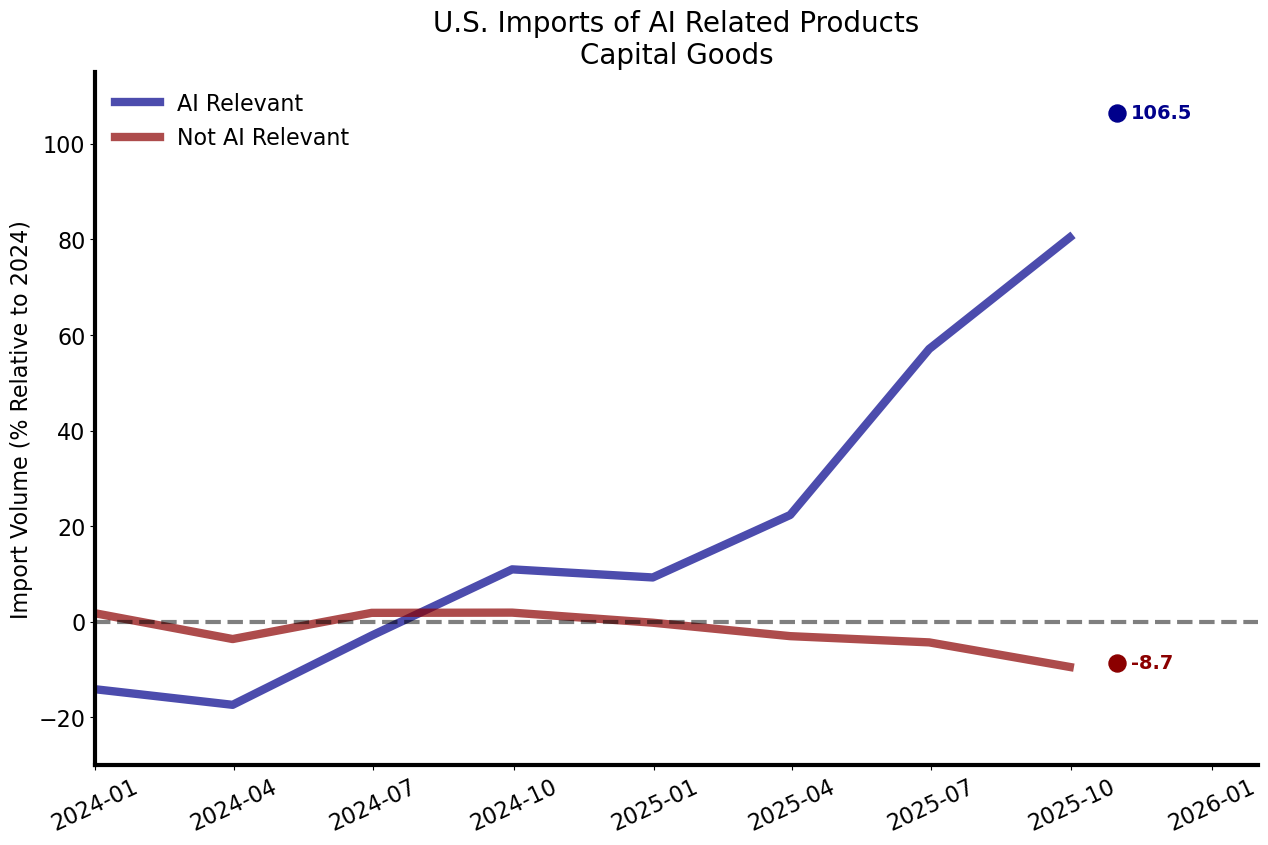

In [28]:
index_year = "2024"

fig, ax = plt.subplots(figsize = (15,9))

# Prepare data for AI Relevant (High)
foo = grp_sum[grp_sum['relevance']=='High'].copy()
foo.set_index('time', inplace=True)
foo = foo.resample('QE').agg({
    'CON_VAL_MO': 'sum'
})

foo_complete = foo.iloc[:-1]
foo_last = foo.iloc[-1]

# Prepare data for Aggregate
foo2 = grp_total.copy()
foo2.set_index('time', inplace=True)
foo2 = foo2.resample('QE').agg({
    'CON_VAL_MO': 'sum'
})
foo2_complete = foo2.iloc[:-1]
foo2_last = foo2.iloc[-1]

# Prepare data for Not AI Relevant (Low)
foo3 = grp_sum[grp_sum['relevance']=='Low'].copy()
foo3.set_index('time', inplace=True)
foo3 = foo3.resample('QE').agg({
    'CON_VAL_MO': 'sum'
})
foo3_complete = foo3.iloc[:-1]
foo3_last = foo3.iloc[-1]

# October date for last incomplete quarter
october_date = dt.datetime(2025, 10, 31)

# Plot AI Relevant (complete quarters)
ax.plot(foo_complete.index, 100*(4*foo_complete["CON_VAL_MO"] / foo["CON_VAL_MO"].loc[index_year].sum() - 1) , 
        color = "darkblue", alpha = 0.7, linewidth = 6, label='AI Relevant')

# Plot AI Relevant last quarter as dot
ax.scatter(october_date, 100*(12*foo_last["CON_VAL_MO"] / foo["CON_VAL_MO"].loc[index_year].sum() - 1),
           color = "darkblue", s=150, zorder=5)

# # Plot Aggregate (complete quarters)
# ax.plot(foo2_complete.index, 100*(4*foo2_complete["CON_VAL_MO"] / foo2["CON_VAL_MO"].loc[index_year].sum()) ,
#          color = "black", alpha = 0.7, linewidth = 6, label='Aggregate')

# # Plot Aggregate last quarter as dot
# ax.scatter(october_date, 100*(12*foo2_last["CON_VAL_MO"] / foo2["CON_VAL_MO"].loc[index_year].sum()),
#            color = "black", s=150, zorder=5)

# Plot Not AI Relevant (complete quarters)
ax.plot(foo3_complete.index, 100*(4*foo3_complete["CON_VAL_MO"] / foo3["CON_VAL_MO"].loc[index_year].sum() - 1) ,
         color = "darkred", alpha = 0.7, linewidth = 6, label='Not AI Relevant')

# Plot Not AI Relevant last quarter as dot
ax.scatter(october_date, 100*(12*foo3_last["CON_VAL_MO"] / foo3["CON_VAL_MO"].loc[index_year].sum() - 1),
           color = "darkred", s=150, zorder=5)

ax.set_title("U.S. Imports of AI Related Products\nCapital Goods", fontsize = 20)

ax.set_xlim([dt.datetime(2024,1,1), dt.datetime(2026,1,31)])

ax.set_ylim(-30,115)

ax.axhline(y=0, color='black', linestyle='--', linewidth=3, alpha=0.5)

ax.tick_params(axis='x', labelsize=16, rotation=25)
ax.tick_params(axis='y', labelsize=16)

ax.set_ylabel(f"Import Volume (% Relative to {index_year})", fontsize=16)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_linewidth(3)
ax.spines["bottom"].set_linewidth(3)

ax.legend(
    fontsize=16,
    frameon=False,
    loc='upper left',
    ncol=1
)

# Add annotations for last observations (aligned with October)
last_value_ai = 100*(12*foo_last["CON_VAL_MO"] / foo["CON_VAL_MO"].loc[index_year].sum() - 1)
ax.annotate(f'{last_value_ai:.1f}', 
            xy=(october_date, last_value_ai),
            xytext=(10, 0), textcoords='offset points',
            fontsize=14, fontweight='bold', color='darkblue',
            va='center')

# last_value_agg = 100*(12*foo2_last["CON_VAL_MO"] / foo2["CON_VAL_MO"].loc[index_year].sum())
# ax.annotate(f'{last_value_agg:.1f}', 
#             xy=(october_date, last_value_agg),
#             xytext=(10, 0), textcoords='offset points',
#             fontsize=14, fontweight='bold', color='black',
#             va='center')

last_value_low = 100*(12*foo3_last["CON_VAL_MO"] / foo3["CON_VAL_MO"].loc[index_year].sum() - 1)
ax.annotate(f'{last_value_low:.1f}', 
            xy=(october_date, last_value_low),
            xytext=(10, 0), textcoords='offset points',
            fontsize=14, fontweight='bold', color='darkred',
            va='center')

# plt.savefig(figfile+"canada-tariffs.png", bbox_inches = "tight")
# plt.savefig(figfile+"canada-tariffs.pdf", bbox_inches = "tight")

plt.show()

In [30]:
foo_complete.tail()

,CON_VAL_MO
time,
2024-09-30,5.810209e+10
2024-12-31,5.721375e+10
2025-03-31,6.405938e+10
2025-06-30,8.224706e+10
2025-09-30,9.446018e+10


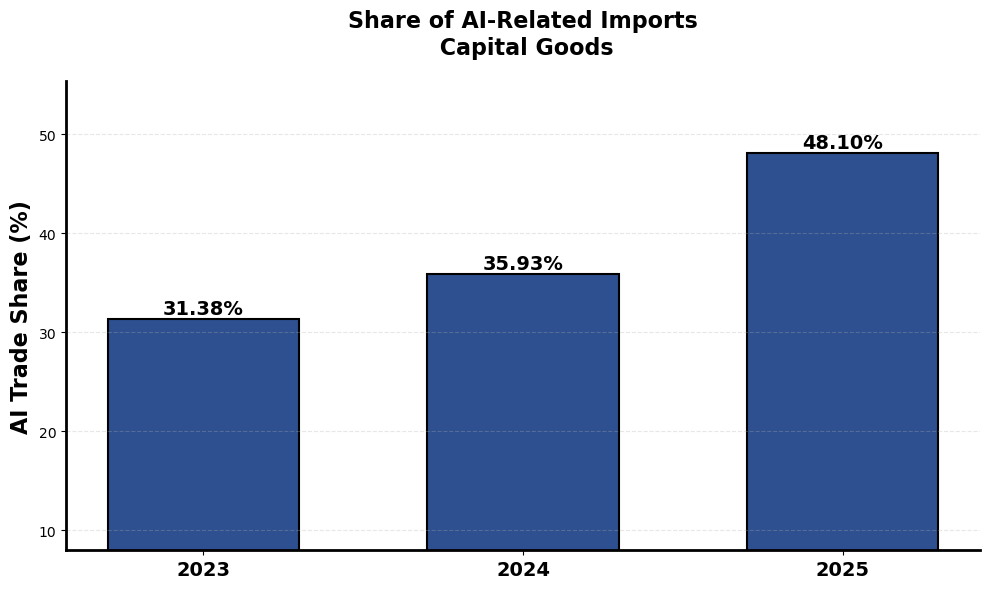


AI Trade Share:
  2023: 31.38%
  2024: 35.93%
  2025: 48.10%

Growth: 16.73 percentage points


In [18]:
# Calculate AI trade share for each year (2023-2025)
years = [2023, 2024, 2025]
ai_shares = []

foo = grp_sum[grp_sum['relevance']=='High'].copy()
foo.set_index("time", inplace=True)
dfsec.set_index("time", inplace=True)

for year in years:
    year_str = str(year)
    total_trade = dfsec.CON_VAL_MO.loc[year_str].sum()
    ai_trade = foo.CON_VAL_MO.loc[year_str].sum()
    ai_share = (ai_trade / total_trade) * 100
    ai_shares.append(ai_share)

# Create bar chart
fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(years, ai_shares, color='#2E5090', edgecolor='black', linewidth=1.5, width=0.6)

# Add value labels on bars
for i, (year, share) in enumerate(zip(years, ai_shares)):
    ax.text(year, share + 0.1, f'{share:.2f}%', 
            ha='center', va='bottom', fontsize=14, fontweight='bold')

# Formatting
# ax.set_xlabel('Year', fontsize=16, fontweight='bold')
ax.set_ylabel('AI Trade Share (%)', fontsize=16, fontweight='bold')
ax.set_title('Share of AI-Related Imports\n Capital Goods', fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(years)
ax.set_ylim(8, max(ai_shares) * 1.15)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Make x-tick labels bold and larger
ax.tick_params(axis='x', labelsize=14)
for label in ax.get_xticklabels():
    label.set_fontweight('bold')

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_linewidth(2)
ax.spines["bottom"].set_linewidth(2)

plt.tight_layout()
plt.show()

print(f"\nAI Trade Share:")
for year, share in zip(years, ai_shares):
    print(f"  {year}: {share:.2f}%")
print(f"\nGrowth: {ai_shares[-1] - ai_shares[0]:.2f} percentage points")

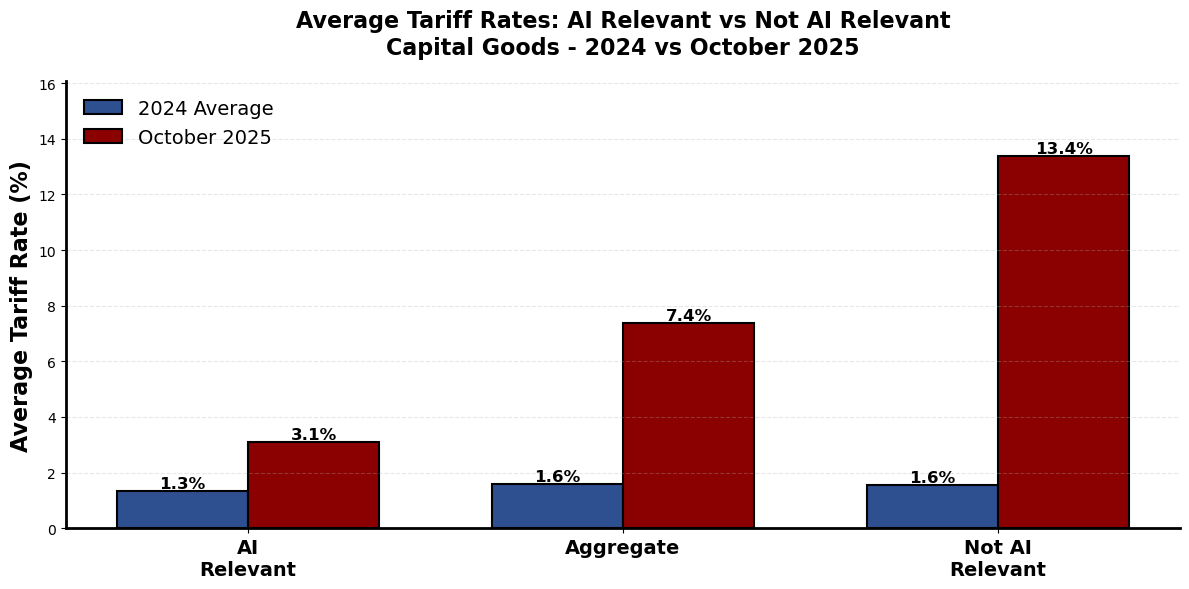


Average Tariff Rates (Capital Goods):
  AI Relevant:
    2024 Average: 1.32%
    October 2025: 3.11%
    Change: 1.79 percentage points
  Aggregate:
    2024 Average: 1.61%
    October 2025: 7.40%
    Change: 5.79 percentage points
  Not AI Relevant:
    2024 Average: 1.56%
    October 2025: 13.38%
    Change: 11.83 percentage points


In [19]:
# Average tariff rates: AI Relevant vs Not AI Relevant - 2024 vs October 2025

# Reset index if time is currently the index
dfsec_temp = dfsec.reset_index() if dfsec.index.name == 'time' else dfsec.copy()

# Calculate tariff rates for AI Relevant (High)
df_ai = dfsec_temp[dfsec_temp['relevance'] == 'High']
tariff_ai_2024 = 100 * df_ai[df_ai['time'].dt.year == 2024]['CAL_DUT_MO'].sum() / df_ai[df_ai['time'].dt.year == 2024]['CON_VAL_MO'].sum()
tariff_ai_oct2025 = 100 * df_ai[(df_ai['time'].dt.year == 2025) & (df_ai['time'].dt.month == 10)]['CAL_DUT_MO'].sum() / df_ai[(df_ai['time'].dt.year == 2025) & (df_ai['time'].dt.month == 10)]['CON_VAL_MO'].sum()

# Calculate tariff rates for Aggregate (all dfsec)
tariff_agg_2024 = 100 * dfsec_temp[dfsec_temp['time'].dt.year == 2024]['CAL_DUT_MO'].sum() / dfsec_temp[dfsec_temp['time'].dt.year == 2024]['CON_VAL_MO'].sum()
tariff_agg_oct2025 = 100 * dfsec_temp[(dfsec_temp['time'].dt.year == 2025) & (dfsec_temp['time'].dt.month == 10)]['CAL_DUT_MO'].sum() / dfsec_temp[(dfsec_temp['time'].dt.year == 2025) & (dfsec_temp['time'].dt.month == 10)]['CON_VAL_MO'].sum()

# Calculate tariff rates for Not AI Relevant (Low)
df_low = dfsec_temp[dfsec_temp['relevance'] == 'Low']
tariff_low_2024 = 100 * df_low[df_low['time'].dt.year == 2024]['CAL_DUT_MO'].sum() / df_low[df_low['time'].dt.year == 2024]['CON_VAL_MO'].sum()
tariff_low_oct2025 = 100 * df_low[(df_low['time'].dt.year == 2025) & (df_low['time'].dt.month == 10)]['CAL_DUT_MO'].sum() / df_low[(df_low['time'].dt.year == 2025) & (df_low['time'].dt.month == 10)]['CON_VAL_MO'].sum()

category_labels = ["AI\nRelevant", "Aggregate", "Not AI\nRelevant"]
tariff_2024 = [tariff_ai_2024, tariff_agg_2024, tariff_low_2024]
tariff_oct2025 = [tariff_ai_oct2025, tariff_agg_oct2025, tariff_low_oct2025]

# Create grouped bar chart
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(category_labels))
width = 0.35

bars1 = ax.bar(x - width/2, tariff_2024, width, label='2024 Average', 
               color='#2E5090', edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, tariff_oct2025, width, label='October 2025',
               color='darkred', edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom', fontsize=12, fontweight='bold')

# Formatting
ax.set_ylabel('Average Tariff Rate (%)', fontsize=16, fontweight='bold')
ax.set_title('Average Tariff Rates: AI Relevant vs Not AI Relevant\nCapital Goods - 2024 vs October 2025', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(category_labels)
ax.legend(fontsize=14, frameon=False, loc='upper left')
ax.set_ylim(0, max(max(tariff_2024), max(tariff_oct2025)) * 1.2)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Make x-tick labels bold and larger
ax.tick_params(axis='x', labelsize=14)
for label in ax.get_xticklabels():
    label.set_fontweight('bold')

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_linewidth(2)
ax.spines["bottom"].set_linewidth(2)

plt.tight_layout()
plt.show()

print(f"\nAverage Tariff Rates (Capital Goods):")
for label, t2024, toct2025 in zip(["AI Relevant", "Aggregate", "Not AI Relevant"], 
                                   tariff_2024, tariff_oct2025):
    print(f"  {label}:")
    print(f"    2024 Average: {t2024:.2f}%")
    print(f"    October 2025: {toct2025:.2f}%")
    print(f"    Change: {toct2025 - t2024:.2f} percentage points")

In [20]:
topproducts = dfsec[dfsec["relevance"]=='High'].loc["2025"]

topproducts = topproducts.groupby("HS10").agg({"CON_VAL_MO": "sum", 
                                               "I_COMMODITY_SDESC": "first",
                                               "specific_use": "first"}).reset_index()

topproducts = topproducts.sort_values(by="CON_VAL_MO", ascending=False).head(20)

In [21]:
topproducts

,HS10,CON_VAL_MO,I_COMMODITY_SDESC,specific_use
48,8471500150,1.223613e+11,"PROC UNT IN HOUS W/ EITHER STOR, IN&OUTPUT,W/O...",Server processors and compute units for AI wor...
138,8517620090,4.229042e+10,MACH FOR RECP/CONVER ETC OF VOICE/IMAGE/DATA N...,"Network switches, routers, and data transmissi..."
137,8517620020,2.380183e+10,SWITCHING AND ROUTING APPARATUS,Network switches and routers for data center i...
62,8471804000,1.016949e+10,"UNITS,NESOI,FOR INCORPORATION INTO ADP MACHINES",Server components and data processing unit mod...
55,8471704065,5.468276e+09,"HARD DISK DRIVE UNT, NESOI, W/OUT EXTNL POWR S...",Data storage drives for servers and storage ar...
60,8471709000,3.250554e+09,"OTHER STORAGE UNITS, NESOI",Data storage devices for servers and storage a...
71,8486900000,3.158561e+09,PARTS & ACCESSORIES FOR MACH/APPS OF HDG 8486,Semiconductor manufacturing equipment for prod...
133,8504409580,2.959124e+09,"STATIC CONVERTERS, NESOI",Power conditioning and voltage conversion for ...
132,8504409570,2.937331e+09,INVERTERS (STATIC CONVERTERS),"Power conversion and conditioning for servers,..."
61,8471801000,2.570120e+09,CONTROL OR ADAPTER UNITS FOR ADP MACHINES,Server control units and hardware adapters for...


In [22]:
excluded_hs2 = ["27", "71",  "98", "99"]

dfsec = df[~df["HS2"].isin(excluded_hs2)]

dfsec = dfsec[dfsec["HS6"].isin(dfenduse[dfenduse["ENDUSE"] == "INT"]["HS6"].unique())]

grp = dfsec.groupby(['relevance', 'time'], observed=False)

grp_sum = grp[['CON_VAL_MO']].sum().reset_index()

grp = dfsec.groupby(['time'], observed=True)

grp_total = grp[['CON_VAL_MO']].sum().reset_index()

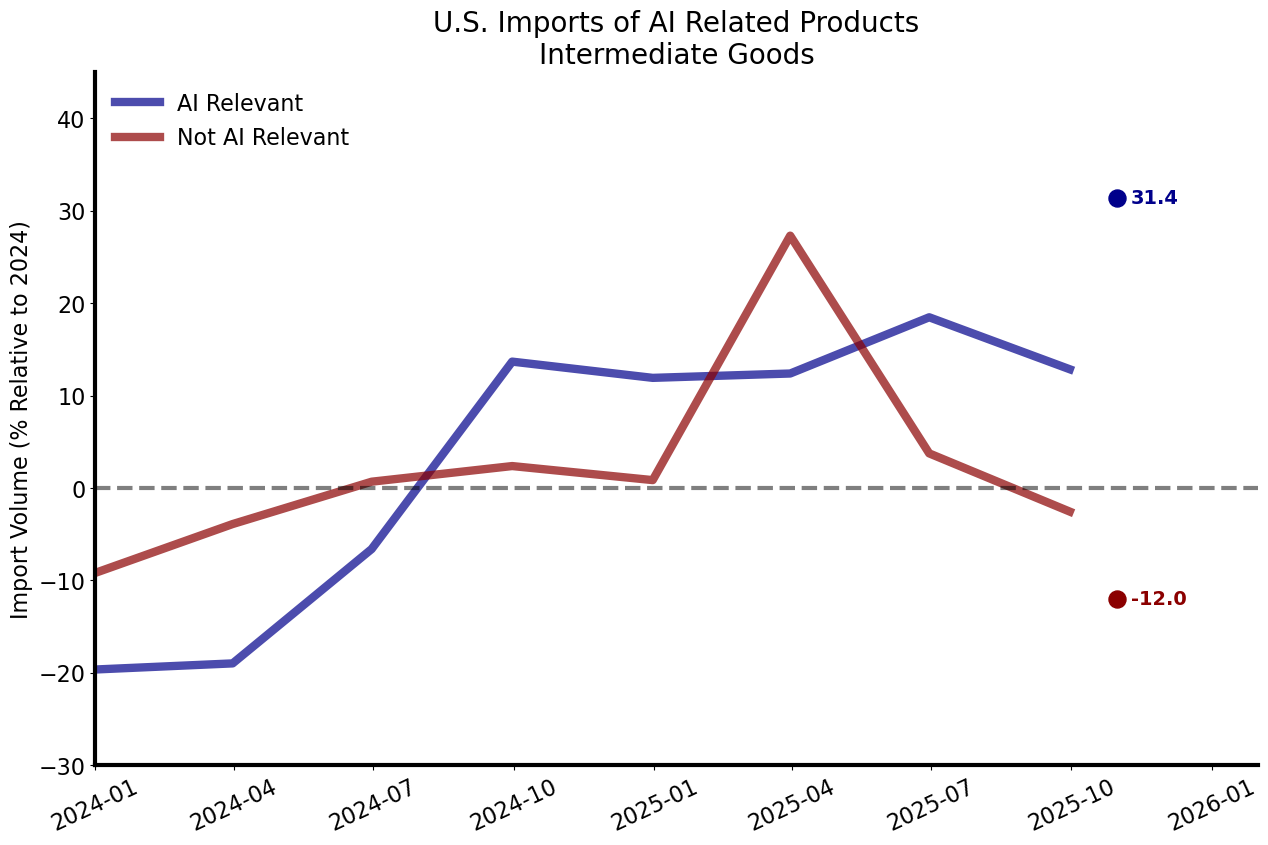

In [23]:
index_year = "2024"

fig, ax = plt.subplots(figsize = (15,9))

# Prepare data for AI Relevant (High)
foo = grp_sum[grp_sum['relevance']=='High'].copy()
foo.set_index('time', inplace=True)
foo = foo.resample('QE').agg({
    'CON_VAL_MO': 'sum'
})

foo_complete = foo.iloc[:-1]
foo_last = foo.iloc[-1]

# Prepare data for Aggregate
foo2 = grp_total.copy()
foo2.set_index('time', inplace=True)
foo2 = foo2.resample('QE').agg({
    'CON_VAL_MO': 'sum'
})
foo2_complete = foo2.iloc[:-1]
foo2_last = foo2.iloc[-1]

# Prepare data for Not AI Relevant (Low)
foo3 = grp_sum[grp_sum['relevance']=='Low'].copy()
foo3.set_index('time', inplace=True)
foo3 = foo3.resample('QE').agg({
    'CON_VAL_MO': 'sum'
})
foo3_complete = foo3.iloc[:-1]
foo3_last = foo3.iloc[-1]

# October date for last incomplete quarter
october_date = dt.datetime(2025, 10, 31)

# Plot AI Relevant (complete quarters)
ax.plot(foo_complete.index, 100*(4*foo_complete["CON_VAL_MO"] / foo["CON_VAL_MO"].loc[index_year].sum() - 1) , 
        color = "darkblue", alpha = 0.7, linewidth = 6, label='AI Relevant')

# Plot AI Relevant last quarter as dot
ax.scatter(october_date, 100*(12*foo_last["CON_VAL_MO"] / foo["CON_VAL_MO"].loc[index_year].sum() - 1),
           color = "darkblue", s=150, zorder=5)

# # Plot Aggregate (complete quarters)
# ax.plot(foo2_complete.index, 100*(4*foo2_complete["CON_VAL_MO"] / foo2["CON_VAL_MO"].loc[index_year].sum() - 1) ,
#          color = "black", alpha = 0.7, linewidth = 6, label='Aggregate')

# # Plot Aggregate last quarter as dot
# ax.scatter(october_date, 100*(12*foo2_last["CON_VAL_MO"] / foo2["CON_VAL_MO"].loc[index_year].sum() - 1),
#            color = "black", s=150, zorder=5)

# Plot Not AI Relevant (complete quarters)
ax.plot(foo3_complete.index, 100*(4*foo3_complete["CON_VAL_MO"] / foo3["CON_VAL_MO"].loc[index_year].sum() - 1) ,
         color = "darkred", alpha = 0.7, linewidth = 6, label='Not AI Relevant')

# Plot Not AI Relevant last quarter as dot
ax.scatter(october_date, 100*(12*foo3_last["CON_VAL_MO"] / foo3["CON_VAL_MO"].loc[index_year].sum() - 1),
           color = "darkred", s=150, zorder=5)

ax.set_title("U.S. Imports of AI Related Products\nIntermediate Goods", fontsize = 20)

ax.set_xlim([dt.datetime(2024,1,1), dt.datetime(2026,1,31)])

ax.set_ylim(-30,45)

ax.axhline(y=0, color='black', linestyle='--', linewidth=3, alpha=0.5)

ax.tick_params(axis='x', labelsize=16, rotation=25)
ax.tick_params(axis='y', labelsize=16)

ax.set_ylabel(f"Import Volume (% Relative to {index_year})", fontsize=16)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_linewidth(3)
ax.spines["bottom"].set_linewidth(3)

ax.legend(
    fontsize=16,
    frameon=False,
    loc='upper left',
    ncol=1
)

# Add annotations for last observations (aligned with October)
last_value_ai = 100*(12*foo_last["CON_VAL_MO"] / foo["CON_VAL_MO"].loc[index_year].sum() - 1)
ax.annotate(f'{last_value_ai:.1f}', 
            xy=(october_date, last_value_ai),
            xytext=(10, 0), textcoords='offset points',
            fontsize=14, fontweight='bold', color='darkblue',
            va='center')

# last_value_agg = 100*(12*foo2_last["CON_VAL_MO"] / foo2["CON_VAL_MO"].loc[index_year].sum() - 1)
# ax.annotate(f'{last_value_agg:.1f}', 
#             xy=(october_date, last_value_agg),
#             xytext=(10, 0), textcoords='offset points',
#             fontsize=14, fontweight='bold', color='black',
#             va='center')

last_value_low = 100*(12*foo3_last["CON_VAL_MO"] / foo3["CON_VAL_MO"].loc[index_year].sum() - 1)
ax.annotate(f'{last_value_low:.1f}', 
            xy=(october_date, last_value_low),
            xytext=(10, 0), textcoords='offset points',
            fontsize=14, fontweight='bold', color='darkred',
            va='center')

# plt.savefig(figfile+"canada-tariffs.png", bbox_inches = "tight")
# plt.savefig(figfile+"canada-tariffs.pdf", bbox_inches = "tight")

plt.show()

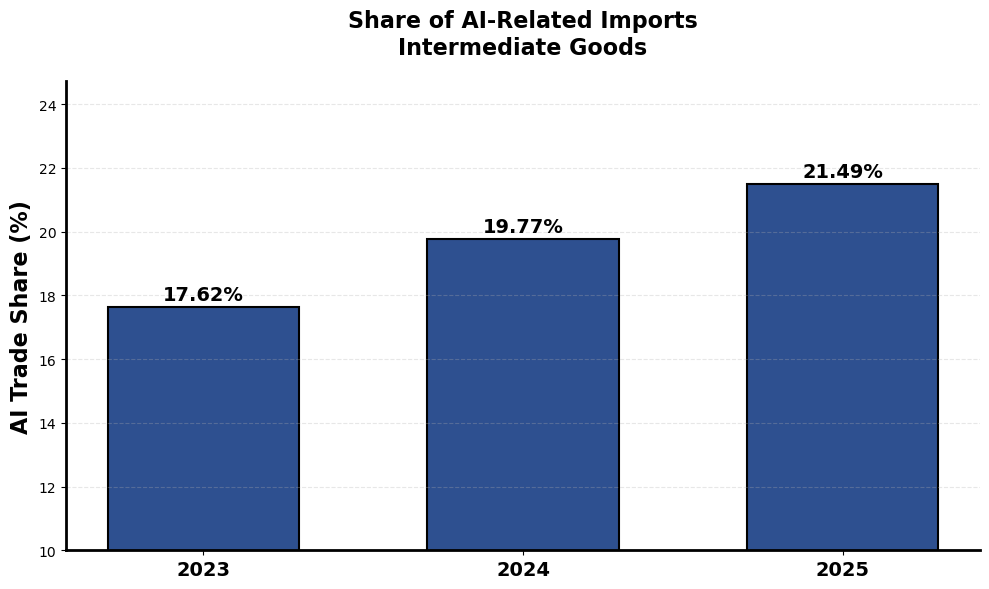


AI Trade Share:
  2023: 17.62%
  2024: 19.77%
  2025: 21.49%

Growth: 3.87 percentage points


In [24]:
# Calculate AI trade share for each year (2023-2025)
years = [2023, 2024, 2025]
ai_shares = []

foo = grp_sum[grp_sum['relevance']=='High'].copy()
foo.set_index("time", inplace=True)
dfsec.set_index("time", inplace=True)

for year in years:
    year_str = str(year)
    total_trade = dfsec.CON_VAL_MO.loc[year_str].sum()
    ai_trade = foo.CON_VAL_MO.loc[year_str].sum()
    ai_share = (ai_trade / total_trade) * 100
    ai_shares.append(ai_share)

# Create bar chart
fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(years, ai_shares, color='#2E5090', edgecolor='black', linewidth=1.5, width=0.6)

# Add value labels on bars
for i, (year, share) in enumerate(zip(years, ai_shares)):
    ax.text(year, share + 0.1, f'{share:.2f}%', 
            ha='center', va='bottom', fontsize=14, fontweight='bold')

# Formatting
# ax.set_xlabel('Year', fontsize=16, fontweight='bold')
ax.set_ylabel('AI Trade Share (%)', fontsize=16, fontweight='bold')
ax.set_title('Share of AI-Related Imports\nIntermediate Goods', fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(years)
ax.set_ylim(10, max(ai_shares) * 1.15)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Make x-tick labels bold and larger
ax.tick_params(axis='x', labelsize=14)
for label in ax.get_xticklabels():
    label.set_fontweight('bold')

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_linewidth(2)
ax.spines["bottom"].set_linewidth(2)

plt.tight_layout()
plt.show()

print(f"\nAI Trade Share:")
for year, share in zip(years, ai_shares):
    print(f"  {year}: {share:.2f}%")
print(f"\nGrowth: {ai_shares[-1] - ai_shares[0]:.2f} percentage points")

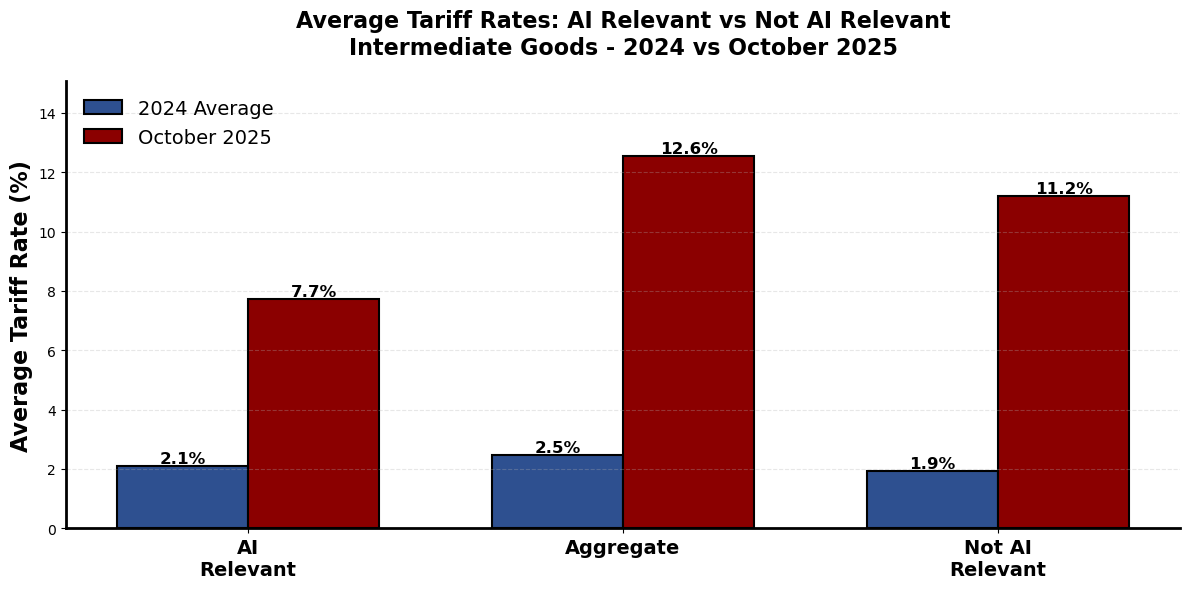


Average Tariff Rates (Intermediate Goods):
  AI Relevant:
    2024 Average: 2.10%
    October 2025: 7.74%
    Change: 5.64 percentage points
  Aggregate:
    2024 Average: 2.46%
    October 2025: 12.55%
    Change: 10.09 percentage points
  Not AI Relevant:
    2024 Average: 1.94%
    October 2025: 11.20%
    Change: 9.26 percentage points


In [25]:
# Average tariff rates: AI Relevant vs Not AI Relevant - 2024 vs October 2025

# Reset index if time is currently the index
dfsec_temp = dfsec.reset_index() if dfsec.index.name == 'time' else dfsec.copy()

# Calculate tariff rates for AI Relevant (High)
df_ai = dfsec_temp[dfsec_temp['relevance'] == 'High']
tariff_ai_2024 = 100 * df_ai[df_ai['time'].dt.year == 2024]['CAL_DUT_MO'].sum() / df_ai[df_ai['time'].dt.year == 2024]['CON_VAL_MO'].sum()
tariff_ai_oct2025 = 100 * df_ai[(df_ai['time'].dt.year == 2025) & (df_ai['time'].dt.month == 10)]['CAL_DUT_MO'].sum() / df_ai[(df_ai['time'].dt.year == 2025) & (df_ai['time'].dt.month == 10)]['CON_VAL_MO'].sum()

# Calculate tariff rates for Aggregate (all dfsec)
tariff_agg_2024 = 100 * dfsec_temp[dfsec_temp['time'].dt.year == 2024]['CAL_DUT_MO'].sum() / dfsec_temp[dfsec_temp['time'].dt.year == 2024]['CON_VAL_MO'].sum()
tariff_agg_oct2025 = 100 * dfsec_temp[(dfsec_temp['time'].dt.year == 2025) & (dfsec_temp['time'].dt.month == 10)]['CAL_DUT_MO'].sum() / dfsec_temp[(dfsec_temp['time'].dt.year == 2025) & (dfsec_temp['time'].dt.month == 10)]['CON_VAL_MO'].sum()

# Calculate tariff rates for Not AI Relevant (Low)
df_low = dfsec_temp[dfsec_temp['relevance'] == 'Low']
tariff_low_2024 = 100 * df_low[df_low['time'].dt.year == 2024]['CAL_DUT_MO'].sum() / df_low[df_low['time'].dt.year == 2024]['CON_VAL_MO'].sum()
tariff_low_oct2025 = 100 * df_low[(df_low['time'].dt.year == 2025) & (df_low['time'].dt.month == 10)]['CAL_DUT_MO'].sum() / df_low[(df_low['time'].dt.year == 2025) & (df_low['time'].dt.month == 10)]['CON_VAL_MO'].sum()

category_labels = ["AI\nRelevant", "Aggregate", "Not AI\nRelevant"]
tariff_2024 = [tariff_ai_2024, tariff_agg_2024, tariff_low_2024]
tariff_oct2025 = [tariff_ai_oct2025, tariff_agg_oct2025, tariff_low_oct2025]

# Create grouped bar chart
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(category_labels))
width = 0.35

bars1 = ax.bar(x - width/2, tariff_2024, width, label='2024 Average', 
               color='#2E5090', edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, tariff_oct2025, width, label='October 2025',
               color='darkred', edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom', fontsize=12, fontweight='bold')

# Formatting
ax.set_ylabel('Average Tariff Rate (%)', fontsize=16, fontweight='bold')
ax.set_title('Average Tariff Rates: AI Relevant vs Not AI Relevant\nIntermediate Goods - 2024 vs October 2025', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(category_labels)
ax.legend(fontsize=14, frameon=False, loc='upper left')
ax.set_ylim(0, max(max(tariff_2024), max(tariff_oct2025)) * 1.2)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Make x-tick labels bold and larger
ax.tick_params(axis='x', labelsize=14)
for label in ax.get_xticklabels():
    label.set_fontweight('bold')

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_linewidth(2)
ax.spines["bottom"].set_linewidth(2)

plt.tight_layout()
plt.show()

print(f"\nAverage Tariff Rates (Intermediate Goods):")
for label, t2024, toct2025 in zip(["AI Relevant", "Aggregate", "Not AI Relevant"], 
                                   tariff_2024, tariff_oct2025):
    print(f"  {label}:")
    print(f"    2024 Average: {t2024:.2f}%")
    print(f"    October 2025: {toct2025:.2f}%")
    print(f"    Change: {toct2025 - t2024:.2f} percentage points")

In [26]:
topproducts = dfsec[dfsec["relevance"]=='High'].loc["2025"]

topproducts = topproducts.groupby("HS10").agg({"CON_VAL_MO": "sum", 
                                               "I_COMMODITY_SDESC": "first",
                                               "specific_use": "first", "reason": "first"}).reset_index()

topproducts = topproducts.sort_values(by="CON_VAL_MO", ascending=False).head(20)

KeyError: "Column(s) ['reason'] do not exist"

In [ ]:
topproducts

,HS10,CON_VAL_MO,I_COMMODITY_SDESC,specific_use
156,8473301180,3.979153e+10,"PTS ADP MCH, NT INCPTNG CRT,PRT CRT ASSEM.;NESOI","Server components, printed circuit boards, and..."
155,8473301140,1.926132e+10,"PTS ADP MCH, NT INCPTG CRT,PRT CT ASM.,MRY MOD...",Server components including memory modules and...
75,7403110000,1.388362e+10,REFINED COPPER CATHODES AND SECTIONS OF CATHODES,"Raw material for electrical wiring, busbars, a..."
190,8523510000,1.373001e+10,SOLID-STATE NON-VOLATILE STORAGE DEVICES,"Data storage devices (SSDs, NVMe drives) for s..."
181,8507600020,1.369338e+10,"LITHIUM-ION STORAGE BATTERIES, NESOI",UPS backup power systems and energy storage
271,8537109170,9.405271e+09,"ELECTRICL APP EQP W/ APPS FM 8535&6,LT 1000V,N...",Electrical distribution panels and control boa...
303,8542310045,8.621903e+09,PRCSSRS (INCL MICRO): CENTRL PROCSSNG UNITS (C...,Server processors for compute nodes in AI clus...
304,8542310050,5.045482e+09,PROCESSORS (INCLUDING MICROPROCESSORS): OTHER,CPUs and microprocessors for servers and compu...
158,8473305100,4.316647e+09,"PTS & ACCESSORIES OF MACH OF HEADING OF 8471,N...","Server and computer system components, replace..."
335,8544429090,4.108070e+09,"INSULATD ELEC CONDCTR LT=1000V,W/ CONNECTRS, N...",Power distribution cables and interconnects fo...
